In [1]:
import os
import tqdm
import math
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.nn.utils import clip_grad_norm_
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
'''

import statsmodels.api as sm

import scipy.stats as ss
import pingouin as pg

import scipy.signal as sci
import math
import scipy as sp

import itertools

from datetime import datetime, timedelta
from datetime import date

import re

import copy
import argparse
import d4rl
from collections import deque'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [2]:
def compute_actions(cuevel, cueDirection, cueposfront, cueposback):
    cueAngle = compute_angle(cueDirection)  #min_max_standardisation(, min_val=45, max_val=135)
    
    #cueacceleration =  normalize(compute_acceleration(cuevel[["x","y","z"]].to_numpy()))      # min_max_standardisation() #, min_val=-140, max_val=140)
    shotMagnitude = compute_impulseForce(cuevel, cueDirection)  #min_max_standardisation_acc()
    actions = np.hstack((cueAngle.reshape(-1,1) , shotMagnitude.reshape(-1,1) ))  #min_max_standardisation_acc(cuevel[["x","y","z"]].to_numpy())))   #, cueacceleration)) #, normalize(cueacceleration))  
    #vel_x = min_max_standardisation(cuevel[["x"]].to_numpy())
    #vel_y = min_max_standardisation(cuevel[["y"]].to_numpy())
    #vel_z = min_max_standardisation(cuevel[["z"]].to_numpy())
    #actions = np.hstack((cueAngle.reshape(-1,1), cueposfront[["x", "y", "z"]].to_numpy(), cueposback[["x", "y", "z"]].to_numpy(), vel_x, vel_y, vel_z))  #, cuevel.to_numpy())
    return actions  #cueAngle, cueMagnitude

def compute_acceleration(cuevel):
    dt = 0.0111
    acc = np.zeros(cuevel.shape)
    for i in range(len(cuevel)):
        if i == 0:
            acc[i][:] = 0   #(np.abs(cuevel[i][:]-0))/dt
        else:
            acc[i][:] = (cuevel[i][:]-cuevel[i-1][:])/dt
            #if np.abs(acc[i][0]) > 10 or np.abs(acc[i][1]) > 10:
                #print("cuevel values for big acc: ", cuevel[i][:], cuevel[i-1][:], i)
    
    return acc
        
def normalize(array):
    #array must be 1-dimensional
    min_val = array.min()
    max_val = np.abs(array).max()
    print("min and max value of acceleration standardization: ", min_val, max_val)
    array = array/max_val
    return array

def min_max_standardisation_acc(array): #=45, max_val=135 ):
    min_val = array.min()
    max_val = array.max()
    print("min and max value of actions standardization: ", min_val, max_val)
    #print("min, max: ", min_val, max_val)
    array = (array - min_val) / (max_val - min_val)
    return array

def min_max_standardisation(array, min_val=0, max_val = 0): #=45, max_val=135 ):
    if min_val == 0:
        min_val = array.min()
        max_val = array.max()
    print("min and max value of actions standardization: ", min_val, max_val)
    #print("min, max: ", min_val, max_val)
    array = (array - min_val) / (max_val - min_val)
    return array

def compute_angle(cuevel, cueDirection):
    #cueAngle1 = np.rad2deg(np.arctan2(cuevel['z'].values, cuevel['x'].values))
    #print("cue Angle vel: ", cueAngle1)
    cueAngle = np.rad2deg(np.arctan2(cueDirection['z'].values, cueDirection['x'].values))
    #print("cue Angle Direction: ", cueAngle)
    return cueAngle

def compute_impulseForce(cuevel, cuedirection):

    #impulseForce = np.zeros(cuevel.shape)       #(N,2)
    #shotMagnitude = np.zeros(1)
    #shotDir = np.zeros(cuedirection.shape)
    #Reward: magnitude range
    #lbMagnitude = 0.1   #0.516149
    #ubMagnitude = 3 #0.882607
    shotMagnitude = np.linalg.norm(cuevel[["x","y","z"]], axis=1)  #np.sqrt(np.square(cuevel).sum(axis=1))
    #np.linalg.norm(cuevel, axis=1)
    """for i in range(cuevel.shape[0]):
        if shotMagnitude[i] > ubMagnitude:
            shotMagnitude[i] = ubMagnitude
        elif shotMagnitude[i] < lbMagnitude:
            shotMagnitude[i] = 0

        shotDir[i][0] = cuedirection["x"].iloc[i]
        shotDir[i][1] = cuedirection["z"].iloc[i]
        if shotMagnitude[i] == 0:
            impulseForce[i][:] = 0
        else:
            impulseForce[i][:] = shotMagnitude[i] * shotDir[i][:]"""
    return shotMagnitude    #, impulseForce

In [3]:
def def_reward(Angle_data): #Success, SuccessFunnel_table, SuccessMedian_table):
    print("Reward function")
    reward = np.zeros(len(Angle_data.Trial))
    
    for i in range(len(Angle_data.Trial)):
        if Angle_data['Success'][i] == 1:
            reward[i] = 1.0
        elif Angle_data['SuccessFunnel'][i] == 1:
            reward[i] = 1.0
        #elif SuccessMedian_table.iloc[i] == 1:     #Agent will not understand reward for trial better than past 10 trials
            #reward[i] = 20
        else:
            reward[i] = 0.0

    return reward

def static_for_n_timesteps(cueballvel, redballvel, timestep, n):
    err = 0.001
    count=0
    for i in range(timestep, timestep+n, 1):
        if np.linalg.norm(cueballvel[["x", "y", "z"]].iloc[i].to_numpy()) < err and np.linalg.norm(redballvel[["x", "y", "z"]].iloc[i].to_numpy()) < err:
            count += 1
    if count == n:
        return True
    else:
        return False

def in_radius_around_cueball(cueballpos, cueposfront):
    radius = 0.001
    if np.linalg.norm(cueballpos[["x", "y", "z"]] - cueposfront[["x", "y", "z"]]) < radius:
        return True
    else:
        return False

def start_hit_timesteps(subjData): #, TrialNumber):
    
    print("start hit timesteps function")
    cueballPos = subjData["cbpos"]
    cueballvel = subjData["cbvel"]
    redballvel = subjData["rbvel"]
    cuevel = subjData["cuevel"]
    #Find when cue hits cueball
    hit_ind=[]
    start_ind=[]
    n = 10
    threshold = 0.1

    miss_hit = False

    prev_trial = 0
    block_until_next_trial = True
    for i in range(len(cueballPos)):
        #The first 200 timesteps approximately are calibration and parasite movements
        if i > 200:   #!= 0:
            #New trial started
            if cueballPos["trial"].iloc[i] > prev_trial:
                if miss_hit == True and len(hit_ind) < len(start_ind):   
                    hit_ind = np.append(hit_ind, start_ind[-1]+350)#on average hitting cueball after 350 timesteps
                    miss_hit = False 
                if static_for_n_timesteps(cueballvel, redballvel, i, n):
                    #Wait for cueball vel y-axis and redball vel y-axis to be zero after new trial started
                    start_ind = np.append(start_ind, i)
                    prev_trial = cueballPos["trial"].iloc[i]
                    block_until_next_trial = False
                    miss_hit = True
            elif cueballPos["trial"].iloc[i] == prev_trial:
                if np.linalg.norm(cueballvel[["x", "y", "z"]].iloc[i].to_numpy()) > threshold and block_until_next_trial == False:
                    #Add 6 timesteps for margin
                    hit_ind = np.append(hit_ind, i+5)
                    block_until_next_trial = True
                    miss_hit = False

        #if last Trial is missed
        if i == len(cueballPos.index) and miss_hit:
            hit_ind = np.append(hit_ind, start_ind[-1]+350)#on average hitting cueball after 350 timesteps

    if len(start_ind) != 250 or len(hit_ind) != 250:
        print("WARNING: either missed a start-hit index, or a trial was not properly recorded")
        #raise ValueError( "Missed an index. start ind size", len(start_ind), "and hit ind size: ", len(hit_ind))
    for i in range(len(start_ind)):
        if start_ind[i] >= hit_ind[i]:
            raise ValueError("start ind > hit_ind", i , start_ind, hit_ind)
    return start_ind.astype(int), hit_ind.astype(int)

In [4]:
def start_hit_reduced_1_timesteps(subjData):
    
    print("start hit timesteps function")
    cueballPos = subjData["cbpos"]
    cueballvel = subjData["cbvel"]
    redballvel = subjData["rbvel"]
    cuevel = subjData["cuevel"]
    #Find when cue hits cueball
    hit_ind=[]
    start_ind=[]
    n = 10
    threshold = 0.06

    start_movement = False

    prev_trial = 0
    start_movement_ind = 0
    window_before_hit = 1   #30  #200
    window_after_hit = 1    #20   #50

    for i in range(len(cueballPos["trial"])):
        #The first 200 timesteps approximately are calibration and parasite movements
        if i > 200:   #!= 0:
            #New trial started
            if cueballPos["trial"].iloc[i] > prev_trial:
                if static_for_n_timesteps(cueballvel, redballvel, i, n):
                    #Wait for cueball vel y-axis and redball vel y-axis to be zero after new trial started
                    start_movement_ind = i
                    start_movement = True
                    prev_trial = cueballPos["trial"].iloc[i]

            elif cueballPos["trial"].iloc[i] == prev_trial and start_movement == True:        
                if np.linalg.norm(cueballvel[["x", "z"]].iloc[i].to_numpy()) > threshold:
                    if len(start_ind) > 0:
                        if cueballPos["trial"][i-window_before_hit] != cueballPos["trial"][start_ind[-1]]:
                            start_ind = np.append(start_ind, i-window_before_hit)
                        else:
                            start_ind = np.append(start_ind, start_movement_ind)
                    else:
                        start_ind = np.append(start_ind, i-window_before_hit)
                    #if cueballPos["trial"][start_ind[i]] == cueballPos["trial"][start_ind[i+1]]:
                        #print("same trial 2 index", start_movement, cueballPos["trial"].iloc[i], prev_trial)
                    hit_ind = np.append(hit_ind, i+window_after_hit)   #+1 when selecting from trajectory
                    start_movement = False
                        
    if len(start_ind) != 250 or len(hit_ind) != 250:
        print("WARNING: either missed a start-hit index, or a trial was not properly recorded")
    for i in range(len(start_ind)-1):
        if cueballPos["trial"][start_ind[i]] == cueballPos["trial"][start_ind[i+1]]:
            print("start index ", i, " and start index ", i+1, "have same trial number")
        if start_ind[i] >= hit_ind[i]:
            raise ValueError("start ind > hit_ind", i , start_ind[i], hit_ind[i])
    return start_ind, hit_ind#.astype(int)

In [5]:
def static_for_n_timesteps(cueballvel, redballvel, timestep, n):
    err = 0.001
    count=0
    for i in range(timestep, timestep+n, 1):
        if np.linalg.norm(cueballvel[["x", "y", "z"]].iloc[i].to_numpy()) < err and np.linalg.norm(redballvel[["x", "y", "z"]].iloc[i].to_numpy()) < err:
            count += 1
    if count == n:
        return True
    else:
        return False

def in_radius_around_cueball(cueballpos, cueposfront):
    radius = 0.1
    if np.linalg.norm(cueballpos[["x", "y", "z"]] - cueposfront[["x", "y", "z"]]) < radius:
        return True
    else:
        return False
def start_hit_reduced_timesteps(subjData):
    
    print("start hit timesteps function")
    cueballPos = subjData["cbpos"]
    cueballvel = subjData["cbvel"]
    redballvel = subjData["rbvel"]
    cuevel = subjData["cuevel"]
    #Find when cue hits cueball
    hit_ind=[]
    start_ind=[]
    n = 10
    threshold = 0.06

    start_movement = False

    prev_trial = 0
    start_movement_ind = 0
    window_before_hit = 100  #200
    window_after_hit = 40   #50
    count_miss = 1

    for i in range(len(cueballPos["trial"])):
        #The first 200 timesteps approximately are calibration and parasite movements
        if i > 200:  
            #New trial started
            if cueballPos["trial"].iloc[i] > prev_trial:
                if cueballPos["trial"].iloc[i]== (len(start_ind) - count_miss):
                    print("WARNING: no start and hit index defined for trial ", prev_trial)
                    count_miss += 1
                if static_for_n_timesteps(cueballvel, redballvel, i, n):    #and in_radius_around_cueball(cueballpos.iloc[i].to_numpy(), cueposfront.iloc[i].to_numpy()):
                    #Wait for cueball vel y-axis and redball vel y-axis to be zero after new trial started
                    start_movement_ind = i
                    start_movement = True
                    prev_trial = cueballPos["trial"].iloc[i]

            elif cueballPos["trial"].iloc[i] == prev_trial and start_movement == True:        
                if np.linalg.norm(cueballvel[["x", "z"]].iloc[i].to_numpy()) > threshold:
                    if len(start_ind) > 0:
                        if cueballPos["trial"][i-window_before_hit] != cueballPos["trial"][start_ind[-1]]:
                            start_ind = np.append(start_ind, i-window_before_hit)
                        else:
                            start_ind = np.append(start_ind, start_movement_ind)
                    else:
                        start_ind = np.append(start_ind, i-window_before_hit)
                    #if cueballPos["trial"][start_ind[i]] == cueballPos["trial"][start_ind[i+1]]:
                        #print("same trial 2 index", start_movement, cueballPos["trial"].iloc[i], prev_trial)
                    hit_ind = np.append(hit_ind, i+window_after_hit)   #+1 when selecting from trajectory
                    start_movement = False
                        
    if len(start_ind) < 250 or len(hit_ind) < 250:
        print("WARNING: either missed a start-hit index, or a trial was not properly recorded")
    for i in range(len(start_ind)-1):
        if cueballPos["trial"][start_ind[i]] == cueballPos["trial"][start_ind[i+1]]:
            print("start index ", i, " and start index ", i+1, "have same trial number")
        if start_ind[i] >= hit_ind[i]:
            raise ValueError("start ind > hit_ind", i , start_ind[i], hit_ind[i])
    return start_ind, hit_ind#.astype(int)

In [6]:
### Warning normalization mean and std should be the same for all positions (otherwise substract mean and we have multiple zero locations)
def normalize(self, eps = 1e-3):
		mean_x = self["x"].mean(0,keepdims=True)
		std_x = self["x"].std(0,keepdims=True) + eps
		mean_y = self["y"].mean(0,keepdims=True)
		std_y = self["y"].std(0,keepdims=True) + eps
		mean_z = self["z"].mean(0,keepdims=True)
		std_z = self["z"].std(0,keepdims=True) + eps
		self["x"] = (self["x"] - mean_x)/std_x
		self["y"] = (self["y"] - mean_x)/std_x
		self["z"] = (self["z"] - mean_x)/std_x

# Import Data

## Import Functions

In [7]:
# Error task

def importDataError (initials, path, pocket, lbThreshold = -9.364594, ubThreshold = 4.675092):

    '''Imports Behavioural Data for a subject performing Error task

    Args:
    - initials (str): initials of the subject
    - path (str): path of the data
    - pocket (str): left/right corresponding to the pocket
    - lbThreshold (float), ubThreshold (float): 
        lower and upper bounds of the interval of possible angles (out of the interval it will be considered outlier)
    
    Output:
    - errorSubjectData (dict): combinations initials (key) - dataframe (value) for each subject with chosen pocket for error task.
        Every entry of the dictionary stores three data frames:
            1. VRData: behavioural data from the unity AAB
            2. angleData: angle of the shot and corresponding trial numbers (250x2)
            3. successData: binary variable for success and corresponding trial numbers (250x2)
    
    '''

    # Declare possible pocket and raise error otherwise
    pockets = ['left', 'right']
    if pocket.lower() in pockets:
        pocket = pocket.capitalize()
    else:
        raise ValueError("Invalid AAB type. Expected one of: %s" % pockets)


    ### Definition of ideal angle and funnel of pocketing ###
    idealAngle = 105.0736
    lb_idealAngle = 104.5401 - idealAngle
    ub_idealAngle = 105.6072 - idealAngle


    ### Import angle data ###
    angleData = pd.read_csv(path + initials + "/AAB/" + initials + "_Angle.txt", header=None, names = ['Angle'])
    angleData['Block'] = np.repeat(range(1,11),25)
    # Remove outliers setting value to nan
    angleData.loc[(angleData.Angle - idealAngle) > ubThreshold, 'Angle'] = np.nan
    angleData.loc[(angleData.Angle - idealAngle) < lbThreshold, 'Angle'] = np.nan   


    ### Import success data ###
    successData = pd.read_csv(path + initials + "/AAB/" + initials + "_Success.txt",  sep = '\t', header = None, \
        names = ['Block','Trial','Angle','Magnitude','RBPosition'], usecols = [0,1,2,3,5])



    ### Import Behavioural Data from Blocks ###
    VRData = pd.DataFrame()

    # Merge all blocks together
    for bl in range(1,11):
        block = pd.read_csv(path + initials + "/Game/" + initials + "_Error" +  pocket + "_Block" + str(bl) + ".txt", sep = '\t')
        # remove shots after 25 trials (done by mistake)
        while block['TrialNumber'].iloc[-1]!=25:
            block.drop(block.tail(1).index,inplace=True)

        block['TrialNumber'] = block['TrialNumber'] + (bl-1)*25  
        VRData = pd.concat([VRData, block])


    ### Store data in a dictionary ###
    errorSubjectData = {}
    names = ['VRData','Angle','Success']
    dfs = [VRData, angleData, successData]
    counter = 0

    for df in names:
        errorSubjectData[df] = dfs[counter]
        counter += 1

    ### Return the dictionary ###
    return(errorSubjectData)





# Reward Task
def importDataReward (initials, path, pocket, lbThreshold = -9.364594, ubThreshold = 4.675092):

    '''Imports Behavioural Data for a subject performing Reward task
    Args:
    - initials (str): initials of the subject
    - path (str): path of the data
    - pocket (str): left/right corresponding to the pocket
    - lbThreshold (float), ubThreshold (float): 
        lower and upper bounds of the interval of possible angles (out of the interval it will be considered outlier)
    
    Output:
    - rewardSubjectData (dict): combinations initials (key) - dataframe (value) for each subject with chosen pocket for reward task
        Every entry of the dictionary stores four data frames:
            1. VRData: behavioural data from the unity game
            2. angleData: angle of the shot and corresponding trial numbers (250x2)
            3. successData: binary variable for success and corresponding trial numbers (250x2)
            4. rewardMotivation: reward motivation (Funnel or Median) and corresponding trial numbers (250x2)
    
    '''

    # Declare possible pocket and raise error otherwise
    pockets = ['left', 'right']
    if pocket.lower() in pockets:
        pocket = pocket.capitalize()
    else:
        raise ValueError("Invalid game type. Expected one of: %s" % pockets)

    ### Definition of ideal angle and funnel ###
    idealAngle = 105.0736
    lb_idealAngle = 104.5401 - idealAngle
    ub_idealAngle = 105.6072 - idealAngle

    ### Import angle data ###
    angleData = pd.read_csv(path + initials + "/Game/" + initials + "_Angle.txt", header=None, names = ['Angle'])
    angleData['Block'] = np.repeat(range(1,11),25)
    # Remove outliers setting values to nan
    angleData.loc[(angleData.Angle - idealAngle) > ubThreshold, 'Angle'] = np.nan
    angleData.loc[(angleData.Angle - idealAngle) < lbThreshold, 'Angle'] = np.nan   

    ### Import success data ###
    successData = pd.read_csv(path + initials + "/Game/" + initials + "_Success.txt",  sep = '\t', header = None, names = ['Block','Trial','Angle','Magnitude','RBPosition'], usecols = [0,1,2,3,5])

    ### Import Reward Motivation (funnel or improvement) ###
    rewardMotivation = pd.read_csv(path + initials + "/Game/" + initials + "_RewardMotivation.txt",  sep = '\t', header = None, names = ['Block', 'Trial','Motivation'])
    rewardMotivation['Trial'] = (rewardMotivation['Block']-1)*25 + rewardMotivation['Trial']


    ### Import Behavioural Data from Blocks ###
    VRData = pd.DataFrame()

    for bl in range(1,11):
        block = pd.read_csv(path + initials + "/Game/" + initials + "_Reward" + pocket + "_Block" + str(bl) + ".txt", sep = '\t')
        while block['TrialNumber'].iloc[-1]!=25:
            block.drop(block.tail(1).index,inplace=True)
        if block['TrialNumber'].iloc[-1]==26:
            print("block: ", bl,block.tail(1).index)
        block['TrialNumber'] = block['TrialNumber'] + (bl-1)*25  
        VRData = pd.concat([VRData, block])
        #print("Block" + str(bl))

    
    ### Store data in a dictionary ###
    rewardSubjectData = {}
    names = ['VRData','Angle','Success','Motivation']
    dfs = [VRData, angleData, successData, rewardMotivation]
    counter = 0

    for df in names:
        rewardSubjectData[df] = dfs[counter]
        counter += 1

    ### Return the dictionary ###    
    return(rewardSubjectData)


## Preprocess

In [8]:
def preprocess(dataset):

    '''Preprocess data from Pool VR returning position of cue ball, red ball, stick and gaze
    
    Args:
    - dataset (pd.Dataframe): VRData (1st dictionary entry of the output of importDataError or importDataReward)
    
    Output:
    - subject (dict): four dataframes for one single subject
        1. cbpos: position of the cue ball (X, Y, Z), trial number, time (in the game) and real time (N x 6)
        2. rbpos: position of the red ball, trial number, time (in the game) and real time (N x 6)
        3. stick: position of the stick, trial number, time (in the game) and real time (N x 6)
        4. gaze: position of the gaze, trial number, time (in the game) and real time (N x 6)
    
    '''

    ### Create string variables from 3D vectors ###
    
    dataset['cueballpos_str'] = dataset['cueballpos'].str.split(',')
    dataset['cueballvel_str'] = dataset['cueballvel'].str.split(',')
    dataset['redballpos_str'] = dataset['redballpos'].str.split(',')
    dataset['redballvel_str'] = dataset['redballvel'].str.split(',')
    dataset['cueposfront_str'] = dataset['cueposfront'].str.split(',')
    dataset['cueposback_str'] = dataset['cueposback'].str.split(',')
    dataset['cuevel_str'] = dataset['cuevel'].str.split(',')
    dataset['cuedirection_str'] = dataset['cuedirection'].str.split(',')
    dataset['corner1pos_str'] = dataset['corner1pos'].str.split(',')
    dataset['corner5pos_str'] = dataset['corner5pos'].str.split(',')
    dataset['corner6pos_str'] = dataset['corner6pos'].str.split(',')
    
    dataset['stick'] = dataset['optifront'].str.split(',')
    dataset['gaze_str'] = dataset['gaze'].str.split(',')

    ### Create datasets from string variables ###
    cbpos = pd.DataFrame.from_records(np.array(dataset['cueballpos_str']), columns=['x','y','z']).astype(float)
    cbvel = pd.DataFrame.from_records(np.array(dataset['cueballvel_str']), columns=['x','y','z']).astype(float)
    rbpos = pd.DataFrame.from_records(np.array(dataset['redballpos_str']), columns=['x','y','z']).astype(float)
    rbvel = pd.DataFrame.from_records(np.array(dataset['redballvel_str']), columns=['x','y','z']).astype(float)
    cueposfront = pd.DataFrame.from_records(np.array(dataset['cueposfront_str']), columns=['x','y','z']).astype(float)
    cueposback = pd.DataFrame.from_records(np.array(dataset['cueposback_str']), columns=['x','y','z']).astype(float)
    cuedirection = pd.DataFrame.from_records(np.array(dataset['cuedirection_str']), columns=['x','y','z']).astype(float)
    cuevel = pd.DataFrame.from_records(np.array(dataset['cuevel_str']), columns=['x','y','z']).astype(float)
    corner1pos = pd.DataFrame.from_records(np.array(dataset['corner1pos_str']), columns=['x','y','z']).astype(float)
    corner5pos = pd.DataFrame.from_records(np.array(dataset['corner5pos_str']), columns=['x','y','z']).astype(float)
    corner6pos = pd.DataFrame.from_records(np.array(dataset['corner6pos_str']), columns=['x','y','z']).astype(float)

    stick = pd.DataFrame.from_records(np.array(dataset['stick']), columns=['x','y','z']).astype(float)
    gaze = pd.DataFrame.from_records(np.array(dataset['gaze_str']), columns=['x','y','z']).astype(float)


    ### Standardise w.r.t cue ball initial position and add time and trial number ###
    #x_std, y_std, z_std = cbpos.iloc[0]
    #d = 0.2 #offset, see cs Script
    #x_ref, y_ref, z_ref = corner1pos.iloc[100]+d  #to be sure position has been calibrated
    #x_scale, y_scale, z_scale = np.abs((corner1pos.iloc[100]-d)-(corner6pos.iloc[100]+d))
    #print("scaling params: ", (x_ref, y_ref, z_ref), (x_scale, y_scale, z_scale))
    for df in (cbpos, rbpos, cueposfront, cueposback, corner5pos, corner6pos, stick, gaze):    # cbvel, rbvel, cuedirection, cuevel, 
        #df -= (x_ref, y_ref, z_ref)
        #df[["x", "z"]] /= (x_scale, z_scale)
        df['trial'] = np.array(dataset['TrialNumber'])
        #df['time'] = np.array(dataset['TrialTime']) 
        #df['timeReal'] = np.array(dataset['GlobalTime'])  
    
    #We don't want to standardize the velocities with respect to cue ball initial position
    for df in (cbvel, rbvel, cuedirection, cuevel):
        df['trial'] = np.array(dataset['TrialNumber'])

    ### Create a dictionary for saving dataframes and save them ###
    subject = {}
    names = ['cbpos', 'cbvel', 'rbpos', 'rbvel', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel', 'corner5pos', 'corner6pos', 'stick','gaze']
    dfs = [cbpos, cbvel, rbpos, rbvel, cueposfront, cueposback, cuedirection, cuevel, corner5pos, corner6pos, stick, gaze]
    counter = 0

    for df in names:
        subject[df] = dfs[counter]
        counter += 1

    ### Return the dictionary ###
    return(subject)

## Success Derivation

In [9]:
def successTrialsError(subject):

    '''Preprocesses and derive successful trials from VR Data correcting the output for error subjects
    
    Args:
    - subject (dict): output of importDataError or importDataReward
    
    Output:
    - subject (dict): copy of the input with correct success definition
    
    '''

    idealAngle = 105.0736
    lb_idealAngle = 104.5401 - idealAngle
    ub_idealAngle = 105.6072 - idealAngle

    
    ### Derive Successful trials from Angle dataset
    subject['Angle']['Success'] = subject['Angle'].Angle.isin(subject['Success']['Angle']).astype(int)
    subject['Angle']['Trial'] = range(1,251)
    subject['Angle']['AngleStd'] =  subject['Angle']['Angle'] - idealAngle

    gameData = preprocess(subject['VRData'])

    succTrials = subject['Angle'].Success.index[subject['Angle'].Success == 1] + 1

    for tr in succTrials:
        cbTrial = gameData['cbpos'][gameData['cbpos'].trial == tr]

        if (cbTrial['y'].iloc[0] - cbTrial['y'].iloc[-1]) >= 0.02:
            subject['Angle'].Success.iloc[tr-1] = 0
    print(str(subject['Success'].shape[0]-sum(subject['Angle'].Success)) + " fake successes removed")


    # Correction if missing successes in perturbation phase for error
    df = subject['Angle'][subject['Angle']['Block'] > 3]
    df = df[df['Block'] < 10]
    if df['Success'].sum()==0:
      for tr in range(76, 226):
          rbTrial = gameData['rbpos'][gameData['rbpos'].trial == tr]
          if (np.abs(np.median(rbTrial['y'].tail(10)) - np.median(rbTrial['y'].head(rbTrial.shape[0]-10))) > 0.02) and (np.abs(np.median(rbTrial['y'].tail(10)) - np.median(rbTrial['y'].head(rbTrial.shape[0]-10))) < 0.5):
              subject['Angle'].Success.iloc[tr-1] = 1
    
    ### Returns preprocessed data with correct success
    return(subject)


def successTrialsReward(subjData, preprocessData):

  '''Preprocesses and derive successful trials from VR Data correcting the output for reward subjects, \
    creating three new variables in the Angle dataset: SuccessMedian (binary variable for success attributable to the median), \
    SuccessFunnel (binary variable for success attributable to the funnel) and Target (reference angle to be rewarded)
  
    Args:
    - subject (dict): output of importDataError or importDataReward
    
    Output:
    - subject (dict): copy of the input with correct success definition and three new variables in the Angle dataset
   
  '''
  
  print("Success Derivation function")
  subject = subjData
  ### Set threshold for funnel ###
  idealAngle = 105.0736
  lb_idealAngle = 104.5401 - idealAngle
  ub_idealAngle = 105.6072 - idealAngle

  ### Derive Successful trials from Angle dataset ###
  ind = subject['Angle']['Block'].isin([1,2,3,10])

  ### Create new variables in Angle dataset: success overall, success due to funnel and success due to improvement ###
  subject['Angle']['Success'] = 0
  subject['Angle']['SuccessFunnel'] = 0
  subject['Angle']['SuccessMedian'] = 0

  ### Add success to angle dataset ###
  subject['Angle']['Success'][ind] = subject['Angle'].Angle[ind].isin(subject['Success']['Angle']).astype(int)

  ### Add trial and standardised angle ###
  subject['Angle']['Trial'] = range(1,251)
  subject['Angle']['AngleStd'] =  subject['Angle']['Angle'] - idealAngle



  ### Preprocess game data ###
  #gameData = preprocess(subject['VRData'])

  ### True Success for baseline blocks ###
  succTrials = subject['Angle'].Success.index[subject['Angle'].Success == 1] + 1
  
  for tr in succTrials:
      cbTrial = preprocessData['cbpos'][preprocessData['cbpos'].trial == tr]

      if (cbTrial['y'].iloc[0] - cbTrial['y'].iloc[-1]) >= 0.02:
          subject['Angle'].Success.iloc[tr-1] = 0

  print(str(succTrials.shape[0]-sum(subject['Angle'].Success)) + " fake successes removed")

  ### Success for perturbation blocks ###
  for tr in subject['Motivation'].Trial:
    #subject['Angle']['Success'].iloc[tr] = 1

    if (subject['Motivation'].Motivation[subject['Motivation'].Trial == tr] == 'Median').all():
      subject['Angle']['SuccessMedian'][tr] = 1
    else:
      subject['Angle']['SuccessFunnel'][tr] = 1 

  ### Derive target for reward (median of the past 10 successful trials) ###

  target = []
  vec_median = list(subject['Angle']['AngleStd'].iloc[range(66,76)])

  for tr in range(76, 226):
    if subject['Angle']['Success'].iloc[tr]==1:
        target.append(min(ub_idealAngle, max(np.median(vec_median), ub_idealAngle-5)))
        vec_median.remove(max(vec_median))
        vec_median.append(subject['Angle']['AngleStd'].iloc[tr])
    else:
        target.append(min(ub_idealAngle, max(np.median(vec_median), ub_idealAngle-5)))

  target_overall = pd.Series(np.concatenate([np.repeat(np.nan, 75), target, np.repeat(np.nan, 25)]))

  subject['Angle']['Target'] = target_overall
  ### Returns preprocessed data with correct success ###
  return(subject)

## Result Single Subject

In [10]:
def resultsSingleSubject(initials, gameType, path, pocket):
    '''
    Produces results for single subject starting from raw data

    Args:
    - initials (str): initials of the subject
    - gameType (str): error/reward - game mode
    - path (str): path of the data
    - pocket (str): left/right - corresponding to the pocket
    
    Output:
    - outputDict (dict): dictionary with two entries:
        1. Game (dict): game data (same output as importDataError/importDataReward) with success corrected
            - VRData: data from the Unity Game
            - Angle: shot directional angles for all trials
            - Success: features of all successful trials
            - Motivation (only for reward task): reason of successful trial (if funnel or improvement of the median)

        2. PreProcessed (dict): pre-processed game data
            - cbpos: position of the cue ball for all timeframes and all trials
            - rbpos: position of the red ball for all timeframes and all trials
            - stick: position of the stick for all timeframes and all trials
            - gaze: position of the gaze


    '''
    
    print("Result Single Subject function")
    # Declare possible gameType and raise error otherwise
    game_types = ['error', 'reward']
    if gameType.lower() in game_types:
        mode = gameType.lower()
    else:
        raise ValueError("Invalid game type. Expected one of: %s" % game_types)



    ##### Error Mode #####
    if mode == 'error':

        # Import Data
        gameData = importDataError(initials, path, pocket) 
        ''' 
        gameData is a dictionary with keys:
        - VRData: data from the Unity Game
        - Angle: shot directional angles for all trials
        - Success: features of all successful trials
        '''

        # Preprocess Data
        preprocData = preprocess(gameData['VRData'])
        '''
        preprocData is a dictionary with keys:
        - cbpos: position of the cue ball for all timeframes and all trials
        - rbpos: position of the red ball for all timeframes and all trials
        - stick: position of the stick for all timeframes and all trials
        - gaze: position of the gaze
        '''

        # Update of Success in Import Data
        gameData = successTrialsError(gameData)



    ##### Reward Mode #####

    elif mode == 'reward':

        # Import Data
        gameData = importDataReward(initials, path, pocket) 
        ''' 
        gameData is a dictionary with keys:
        - VRData: data from the Unity Game
        - Angle: shot directional angles for all trials
        - Success: features of all successful trials
        - Motivation: reason of successful trial (if funnel or improvement of the median)
        '''

        # Preprocess Data
        preprocData = preprocess(gameData['VRData'])
        '''
        preprocData is a dictionary with keys:
        - cbpos: position of the cue ball for all timeframes and all trials
        - rbpos: position of the red ball for all timeframes and all trials
        - stick: position of the stick for all timeframes and all trials
        - gaze: position of the gaze
        '''

        # Update of Success in Import Data
        angleData = successTrialsReward(gameData, preprocData)


    ### List of outputs ###
    outputDict = {}
    outputDict['Game'] = gameData 
    outputDict['PreProcessed'] = preprocData
    outputDict['Angle'] = angleData
    return(outputDict)


In [11]:
def resultsMultipleSubjects(path, sub, gameType, pocketSide):
    '''
    Args:
    - pathList (list): list of all paths of the folder with raw data
    - gameType (str): error/reward - game type 
    - pocketSide (str): left/right - game pocket
 
    '''
	
    print("result Multiple Subject function")
    # Declare possible gameType and raise error otherwise
    game_types = ['error', 'reward']
    if gameType.lower() in game_types:
        mode = gameType.lower()
    else:
        raise ValueError("Invalid game type. Expected one of: %s" % game_types)

    # Call dataframe for both rounds together
    dataset = {}
    
    # Declare possible pocketSide and raise error otherwise
    pocketChoice = ['left', 'right', 'all']
    if pocketSide.lower() in pocketChoice:
        pocket = pocketSide.lower()
    else:
        raise ValueError("Invalid pocket. Expected one of: %s" % pocketChoice)


    print(path, sub)
    if mode == 'reward':

        # Derive path for a specific subject and game type
        pathSubj = path + str(sub)
        for fil in range(len(sorted(os.listdir(pathSubj + '/Game/')))):
            if sorted(os.listdir(pathSubj + '/Game/'))[fil].find("Block2") > -1:
                blockFile = sorted(os.listdir(pathSubj + '/Game/'))[fil]


        if (blockFile.find('Left') > -1 and pocket != 'right'):
            pocketSub = 'Left'
        elif (blockFile.find('Right') > -1 and pocket != 'left'):
            pocketSub = 'Right'
        else:
            pocketSub = 'None'

        if blockFile.find('Reward') > -1:
            # Derive initials of the subject
            initials = os.path.basename(pathSubj)

            # Derive All Results for One Subject
            subjData = resultsSingleSubject(initials, 'reward', path, pocketSub)

            # Add data to dataframes previously defined
            dataset[str(initials)]={}

            dataset[str(initials)]["rewards"] = def_reward(subjData["Angle"]["Angle"])  #["Success"], subjData["Angle"]["Angle"]["SuccessMedian"], subjData["Angle"]["Angle"]["SuccessFunnel"])


            dataset[str(initials)]["cueballpos"] = subjData["PreProcessed"]["cbpos"]
            dataset[str(initials)]["cueballvel"] = subjData["PreProcessed"]["cbvel"]
            
            dataset[str(initials)]["start_ind"], dataset[str(initials)]["hit_ind"] = start_hit_reduced_timesteps(subjData["PreProcessed"])  # start_hit_timesteps(subjData["PreProcessed"])     
            dataset[str(initials)]["start_ind"] = dataset[str(initials)]["start_ind"].astype(int)
            dataset[str(initials)]["hit_ind"] = dataset[str(initials)]["hit_ind"].astype(int)
            dataset[str(initials)]["redballpos"] = subjData["PreProcessed"]["rbpos"]
            
            if pocketSub == 'Left':
                dataset[str(initials)]["targetcornerpos"] = subjData["PreProcessed"]["corner5pos"]
            else:
                dataset[str(initials)]["targetcornerpos"] = subjData["PreProcessed"]["corner6pos"]

            dataset[str(initials)]["cueposfront"] = subjData["PreProcessed"]["cueposfront"]

            dataset[str(initials)]["cueposback"] = subjData["PreProcessed"]["cueposback"]

            dataset[str(initials)]["cuedirection"] = subjData["PreProcessed"]["cuedirection"]

            dataset[str(initials)]["cuevel"] = subjData["PreProcessed"]["cuevel"]

            #dataset[str(initials)]["rewards"] = def_reward(subjData['Game']["Angle"]["Success"], subjData["Game"]["Angle"]["SuccessFunnel"], subjData["Game"]["Angle"]["SuccessMedian"])

            print("Imported " + initials + " as reward subject " + "for " + pocketSub + " pocket" + " in round: " + path)
            
    return dataset

## Results Multiple Subjects

In [12]:
def resultsMultipleSubjects(path, sub, gameType, pocketSide):
    '''
    Args:
    - pathList (list): list of all paths of the folder with raw data
    - gameType (str): error/reward - game type 
    - pocketSide (str): left/right - game pocket
 
    '''
	
    print("result Multiple Subject function")
    # Declare possible gameType and raise error otherwise
    game_types = ['error', 'reward']
    if gameType.lower() in game_types:
        mode = gameType.lower()
    else:
        raise ValueError("Invalid game type. Expected one of: %s" % game_types)

    # Call dataframe for both rounds together
    dataset = {}
    
    # Declare possible pocketSide and raise error otherwise
    pocketChoice = ['left', 'right', 'all']
    if pocketSide.lower() in pocketChoice:
        pocket = pocketSide.lower()
    else:
        raise ValueError("Invalid pocket. Expected one of: %s" % pocketChoice)


    print(path, sub)
    if mode == 'reward':

        # Derive path for a specific subject and game type
        pathSubj = path + str(sub)
        for fil in range(len(sorted(os.listdir(pathSubj + '/Game/')))):
            if sorted(os.listdir(pathSubj + '/Game/'))[fil].find("Block2") > -1:
                blockFile = sorted(os.listdir(pathSubj + '/Game/'))[fil]


        if (blockFile.find('Left') > -1 and pocket != 'right'):
            pocketSub = 'Left'
        elif (blockFile.find('Right') > -1 and pocket != 'left'):
            pocketSub = 'Right'
        else:
            pocketSub = 'None'

        if blockFile.find('Reward') > -1:
            # Derive initials of the subject
            initials = os.path.basename(pathSubj)

            # Derive All Results for One Subject
            subjData = resultsSingleSubject(initials, 'reward', path, pocketSub)

            # Add data to dataframes previously defined
            dataset[str(initials)]={}

            dataset[str(initials)]["rewards"] = def_reward(subjData["Angle"]["Angle"])  #["Success"], subjData["Angle"]["Angle"]["SuccessMedian"], subjData["Angle"]["Angle"]["SuccessFunnel"])


            dataset[str(initials)]["cueballpos"] = subjData["PreProcessed"]["cbpos"]
            dataset[str(initials)]["cueballvel"] = subjData["PreProcessed"]["cbvel"]
            
            dataset[str(initials)]["start_ind"], dataset[str(initials)]["hit_ind"] = start_hit_reduced_timesteps(subjData["PreProcessed"])  # start_hit_timesteps(subjData["PreProcessed"])     
            dataset[str(initials)]["start_ind"] = dataset[str(initials)]["start_ind"].astype(int)
            dataset[str(initials)]["hit_ind"] = dataset[str(initials)]["hit_ind"].astype(int)
            dataset[str(initials)]["redballpos"] = subjData["PreProcessed"]["rbpos"]
            
            if pocketSub == 'Left':
                dataset[str(initials)]["targetcornerpos"] = subjData["PreProcessed"]["corner5pos"]
            else:
                dataset[str(initials)]["targetcornerpos"] = subjData["PreProcessed"]["corner6pos"]

            dataset[str(initials)]["cueposfront"] = subjData["PreProcessed"]["cueposfront"]

            dataset[str(initials)]["cueposback"] = subjData["PreProcessed"]["cueposback"]

            dataset[str(initials)]["cuedirection"] = subjData["PreProcessed"]["cuedirection"]

            dataset[str(initials)]["cuevel"] = subjData["PreProcessed"]["cuevel"]

            #dataset[str(initials)]["rewards"] = def_reward(subjData['Game']["Angle"]["Success"], subjData["Game"]["Angle"]["SuccessFunnel"], subjData["Game"]["Angle"]["SuccessMedian"])

            print("Imported " + initials + " as reward subject " + "for " + pocketSub + " pocket" + " in round: " + path)
            
    return dataset

## Extract info

### Offline Reduced timesteps Version

In [13]:
def Offline_reduced(data, cue_data, cuevel, rewards, state_dim=14, action_dim=2):   #state_dim should be a multiple of 6
    
    print("Offline RL Dataset function")
    #number of trial
    N = len(data["cueballpos"]["trial"])-1   #len(data[initial]["start_ind"])
    print(N)
    state_ = []
    new_state_ = []
    action_ = []
    reward_ = []
    done_ = []
    trial_ = []

    state = np.zeros(state_dim)  #np.zeros(21)
    new_state = np.zeros(state_dim)  #np.zeros(21)
    #action = np.zeros(13)   #12)
    #action = np.zeros(action_dim)
    #reward = np.zeros(1)
    #ball_states=6
    #cue_states=6
    #cue_states_iterations = int((state_dim-ball_states)/(cue_states))

    #Action Velocity, Force?
    #See car 2D -> action space acceleration and cueDirection
    #actions = compute_actions(cuevel[["x", "z"]], cue_data["cuedirection"][["x", "z"]], cue_data["cueposfront"][["x", "z"]], cue_data["cueposback"][["x", "z"]])
    actions = compute_actions(cuevel, cue_data["cuedirection"], cue_data["cueposfront"], cue_data["cueposback"])
   
    for i in range(N):
        count=0
        #count_action=0
        for x in data:
            state[count] = data[str(x)]["x"].iloc[i]
            state[count+1] = data[str(x)]["y"].iloc[i]
            state[count+2] = data[str(x)]["z"].iloc[i]
            new_state[count] = data[str(x)]["x"].iloc[i+1]
            new_state[count+1] = data[str(x)]["y"].iloc[i+1]
            new_state[count+2] = data[str(x)]["z"].iloc[i+1]
            count+=3

        #Add last j timesteps of the cuepos to states
        #3 observations on x and z axis makes 6 observations
        #for j in range(cue_states_iterations): #Warning if state_dim not multiple of 6, division fail for loop
        for x in cue_data:
            state[count] = cue_data[str(x)]["x"].iloc[i]
            state[count+1] = cue_data[str(x)]["y"].iloc[i]
            state[count+2] = cue_data[str(x)]["z"].iloc[i]
            new_state[count] = cue_data[str(x)]["x"].iloc[i+1]
            new_state[count+1] = cue_data[str(x)]["y"].iloc[i+1]
            new_state[count+2] = cue_data[str(x)]["z"].iloc[i+1]
            '''if x == "cueposfront" or x == "cueposback" or x == "cuevel":
                action[count_action] = cue_data[str(x)]["x"].iloc[i+1]
                action[count_action+1] = cue_data[str(x)]["y"].iloc[i+1]
                action[count_action+2] = cue_data[str(x)]["z"].iloc[i+1]
                count_action+=3'''
            count+=3
            
        #Action Velocity, Force?
        action = actions[i+1][:]  #[count_action:]    #actions[:,i+1] #action is cuepos at t+1
        reward = rewards.iloc[i]
        
        if i == N-1:        #No last timestep due to new_states, so advance reward for the last trial
            done_bool = 1 
            reward = rewards.iloc[i+1]  
        elif data['cueballpos']['trial'].iloc[i+1] != data['cueballpos']['trial'].iloc[i]:
            done_bool = 1   #True
        else:
            done_bool = 0   #False

        trial_.append(data["cueballpos"]["trial"].iloc[i])
        state_.append(state.copy())
        new_state_.append(new_state.copy())
        action_.append(action.copy())
        reward_.append(reward)
        done_.append(done_bool)
    
    return {
        'trial': np.array(trial_),
        'states': np.array(state_),
        'actions': np.array(action_),
        'new_states': np.array(new_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        }

### Offline dict One

In [14]:
def Offline_One(data, cue_data, cuevel, rewards, state_dim=24, action_dim=2):   #state_dim should be a multiple of 6
    
    print("Offline RL Dataset function")
    #number of trial
    N = len(data["cueballpos"]["trial"]) -1   #len(data[initial]["start_ind"])
    state_ = []
    new_state_ = []
    action_ = []
    reward_ = []
    done_ = []
    trial_ = []

    state = np.zeros(state_dim)  #np.zeros(21)
    new_state = np.zeros(state_dim)  #np.zeros(21)
    action = np.zeros(action_dim)
    #reward = np.zeros(1)
    #gamma = 0.6
    ball_states=6
    cue_states=6
    cue_states_iterations = int((state_dim-ball_states)/(cue_states))
    #Action Velocity, Force?
    #See car 2D -> action space acceleration and cueDirection
    actions = compute_impulseForce(cuevel[["x", "z"]], cue_data["cuedirection"][["x", "z"]])
        
    for i in range(N):
        count=0
        for x in data:
            state[count] = data[str(x)]["x"].iloc[i]
            state[count+1] = data[str(x)]["z"].iloc[i]
            new_state[count] = data[str(x)]["x"].iloc[i+1]
            new_state[count+1] = data[str(x)]["z"].iloc[i+1]
            count+=2

        #Add last j timesteps of the cuepos to states
        #3 observations on x and z axis makes 6 observations
        for j in range(cue_states_iterations): #Warning if state_dim not multiple of 6, division fail for loop
            for x in cue_data:
                state[count] = cue_data[str(x)]["x"].iloc[i-j]
                state[count+1] = cue_data[str(x)]["z"].iloc[i-j]
                new_state[count] = cue_data[str(x)]["x"].iloc[i+1-j]
                new_state[count+1] = cue_data[str(x)]["z"].iloc[i+1-j]
                count+=2
   
        #Action Velocity, Force?
        action = actions[i][:]
        #reward = rewards[i]
        
        if data['cueballpos']['trial'].iloc[i+1] != data['cueballpos']['trial'].iloc[i]:
            done_bool = True
            reward = rewards.iloc[i]
        else:
            done_bool = False
            reward=0

        trial_.append(data["cueballpos"]["trial"].iloc[i])
        state_.append(state.copy())
        new_state_.append(new_state.copy())
        action_.append(action.copy())
        reward_.append(reward)
        done_.append(done_bool)
    
    return {
        'trial': np.array(trial_),
        'states': np.array(state_),
        'actions': np.array(action_),
        'new_states': np.array(new_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        }

def compute_impulseForce_load(self, cuevel, cuedirection):
    impulseForce = np.zeros(cuevel.shape)       #(N,2)
    shotMagnitude = np.zeros(1)
    shotDir = np.zeros(cuedirection.shape)
    #Reward: magnitude range
    lbMagnitude = 0.4   #0.516149
    ubMagnitude = 0.882607

    shotMagnitude = np.linalg.norm(cuevel, axis=1)

    for i in range(cuevel.shape[0]):
        if shotMagnitude[i] > ubMagnitude:
            shotMagnitude[i] = ubMagnitude
            #print("upper bounded")
        #elif shotMagnitude[i] > lbMagnitude:
            #print(i, shotMagnitude[i])
        elif shotMagnitude[i] < lbMagnitude:
            shotMagnitude[i] = 0

        shotDir[i][:] = cuedirection[i][:]
        if shotMagnitude[i] == 0:
            impulseForce[i][:] = 0
        else:
            impulseForce[i][:] = shotMagnitude[i] * shotDir[i][:]
    return impulseForce

### Offline RL One dict

In [15]:
def Offline_One_big_dict(data,initial, terminate_on_end=False):
    
    print("Offline RL Dataset function")
    #number of trial
    N = data[initial]["cueballpos"]["trial"].iloc[-1]    #len(data[initial]["start_ind"])
    state_ = []
    new_state_ = []
    action_ = []
    reward_ = []
    done_ = []
    trial_ = []

    state = np.zeros(14)  #np.zeros(21)
    new_state = np.zeros(14)  #np.zeros(21)
    action = np.zeros(2)
    reward = np.zeros(1)
    #gamma = 0.6
    episode_step=0
    for i in range(N):
        for j in range(data[initial]["start_ind"][i], data[initial]["hit_ind"][i]+1, 1):
            #state timestep t
            state[0] = data[initial]["cueballpos"]["x"].iloc[j] 
            #state[0] = data[initial]["cueballpos"][y].iloc[j] 
            state[1] = data[initial]["cueballpos"]["z"].iloc[j] 
            state[2] = data[initial]["redballpos"]["x"].iloc[j] 
            #state[2] = data[initial]["redballpos"][y].iloc[j]
            state[3] = data[initial]["redballpos"]["z"].iloc[j]
            state[4] = data[initial]["targetcornerpos"]["x"].iloc[j]
            #state[4] = data[initial]["targetcornerpos"]["y"].iloc[j]
            state[5] = data[initial]["targetcornerpos"]["z"].iloc[j]
            state[6] = data[initial]["cueposfront"]["x"].iloc[j]
            #state[6] = data[initial]["cueposfront"][y].iloc[j]
            state[7] = data[initial]["cueposfront"]["z"].iloc[j]
            state[8] = data[initial]["cueposback"]["x"].iloc[j]
            #state[8] = data[initial]["cueposback"][y].iloc[j]
            state[9] = data[initial]["cueposback"]["z"].iloc[j]
            state[10] = data[initial]["cuedirection"]["x"].iloc[j]
            #state[10] = data[initial]["cueDirection"][y].iloc[j]
            state[11] = data[initial]["cuedirection"]["z"].iloc[j]
            state[12] = data[initial]["cuevel"]["x"].iloc[j]
            state[13] = data[initial]["cuevel"]["z"].iloc[j]

            #state Timestep t+1
            new_state[0] = data[initial]["cueballpos"]["x"].iloc[j+1] 
            #new_state[0] = data[initial]["cueballpos"][y].iloc[j+1] 
            new_state[1] = data[initial]["cueballpos"]["z"].iloc[j+1] 
            new_state[2] = data[initial]["redballpos"]["x"].iloc[j+1] 
            #new_state[2] = data[initial]["redballpos"][y].iloc[j+1]
            new_state[3] = data[initial]["redballpos"]["z"].iloc[j+1]
            new_state[4] = data[initial]["targetcornerpos"]["x"].iloc[j+1]
            #new_state[4] = data[initial]["targetcornerpos"]["y"].iloc[j+1]
            new_state[5] = data[initial]["targetcornerpos"]["z"].iloc[j+1]
            new_state[6] = data[initial]["cueposfront"]["x"].iloc[j+1]
            #new_state[6] = data[initial]["cueposfront"][y].iloc[j+1]
            new_state[7] = data[initial]["cueposfront"]["z"].iloc[j+1]
            new_state[8] = data[initial]["cueposback"]["x"].iloc[j+1]
            #new_state[8] = data[initial]["cueposback"][y].iloc[j+1]
            new_state[9] = data[initial]["cueposback"]["z"].iloc[j+1]
            new_state[10] = data[initial]["cuedirection"]["x"].iloc[j+1]
            #new_state[10] = data[initial]["cueDirection"][y].iloc[j+1]
            new_state[11] = data[initial]["cuedirection"]["z"].iloc[j+1]
            new_state[12] = data[initial]["cuevel"]["x"].iloc[j+1]
            new_state[13] = data[initial]["cuevel"]["z"].iloc[j+1]

            #Action Velocity, Force?
            action = compute_impulseForce(data[initial]["cuevel"][["x", "z"]].iloc[j], data[initial]["cuedirection"][["x", "z"]].iloc[j])
            #action[0] = data[initial]["cuevel"]["y"].iloc[j]
            

            if j == data[initial]["hit_ind"][i]:
                done_bool = True
                reward = data[initial]["rewards"][i]
            else:
                done_bool = False
                ## Discounted reward ##
                #reward = gamma**(j - data[initial]["hit_ind"][i]) * data[initial]["rewards"][i]
                reward = 0

            final_timestep = (episode_step == data[initial]["hit_ind"][i]-1)
            if (not terminate_on_end) and final_timestep:
                # Skip this transition and don't apply terminals on the last step of an episode
                episode_step = 0
                continue
            if done_bool or final_timestep:
                episode_step = 0

            trial_.append(data[initial]["cueballpos"]["trial"].iloc[j] )
            state_.append(state)
            new_state_.append(new_state)
            action_.append(action)
            reward_.append(reward)
            done_.append(done_bool)
            episode_step += 1
    
    return {
        'trial': np.array(trial_),
        'states': np.array(state_),
        'actions': np.array(action_),
        'new_states': np.array(new_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        }

### Offline load class

In [16]:
class Offline_RL_dataset(object): #rewards,cueballpos,redballpos, targetcornerpos, cueposfront, cueposback, cuedirection, cuevel,
    def __init__(self, state_dim=14, action_dim=2, nb_trial=250):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #number of trial
        self.N = nb_trial    #int(cueballpos[0].iloc[-1])
        self.state_dim = state_dim  
        self.action_dim = action_dim
        self.trajectories = []
        
        self.mean = np.zeros(self.state_dim)
        self.std = np.zeros(self.state_dim)

    def get_trajectories(self, list_data, rewards):
        
        state_ = []
        new_state_ = []
        action_ = []
        reward_ = []
        done_ = []

        state = np.zeros(self.state_dim)
        new_state = np.zeros(self.state_dim) 
        action = np.zeros(self.action_dim)
        reward = np.zeros(1)

        actions = self.compute_impulseForce_load(np.transpose(np.array([list_data["cuevel"][1], list_data["cuevel"][3]])), np.transpose(np.array([list_data["cuedirection"][1], list_data["cuedirection"][3]])))

        for i in range(len(list_data["cueballpos"])-1):
            count=0
            for x in list_data:
                state[count] = list_data[str(x)][1].iloc[i]
                state[count+1] = list_data[str(x)][3].iloc[i]
                new_state[count] = list_data[str(x)][1].iloc[i+1]
                new_state[count+1] = list_data[str(x)][3].iloc[i+1]
                count+=2
            #Action Velocity, Force?
            action = actions[i][:]
            reward = rewards.iloc[i]
            
            if cueballpos[0].iloc[i+1] != cueballpos[0].iloc[i]:
                done_bool = True
            else:
                done_bool = False

            state_.append(state.copy())
            new_state_.append(new_state.copy())
            action_.append(action.copy())
            reward_.append(reward.copy())
            done_.append(done_bool)

            if list_data["cueballpos"][0].iloc[i+1] != list_data["cueballpos"][0].iloc[i]:
                self.trajectories.append({
                'size': np.array(state_).shape[0],
                'states': np.array(state_),
                'actions': np.array(action_),
                'new_states': np.array(new_state_),
                'rewards': np.array(reward_),
                'terminals': np.array(done_),
                })

    def sample(self):   #, batch_size = 4):   #bacth size is the number of trajectory processed before gradient update
        max_size = self.N
        ind = 1 #np.random.randint(0, max_size)    #, size=batch_size)
        return (torch.FloatTensor(self.trajectories[ind]['size']).to(self.device),
            torch.FloatTensor(self.trajectories[ind]['states']).to(self.device),
            torch.FloatTensor(self.trajectories[ind]['actions']).to(self.device),
            torch.FloatTensor(self.trajectories[ind]['new_states']).to(self.device),
            torch.FloatTensor(self.trajectories[ind]['rewards']).to(self.device),
            torch.FloatTensor(self.trajectories[ind]['terminals']).to(self.device))

    def compute_impulseForce_load(self, cuevel, cuedirection):
        impulseForce = np.zeros(cuevel.shape)       #(N,2)
        shotMagnitude = np.zeros(1)
        shotDir = np.zeros(cuedirection.shape)
        #Reward: magnitude range
        lbMagnitude = 0.4   #0.516149
        ubMagnitude = 0.882607

        shotMagnitude = np.linalg.norm(cuevel, axis=1)

        for i in range(cuevel.shape[0]):
            if shotMagnitude[i] > ubMagnitude:
                shotMagnitude[i] = ubMagnitude
                #print("upper bounded")
            #elif shotMagnitude[i] > lbMagnitude:
                #print(i, shotMagnitude[i])
            elif shotMagnitude[i] < lbMagnitude:
                shotMagnitude[i] = 0

            shotDir[i][:] = cuedirection[i][:]
            if shotMagnitude[i] == 0:
                impulseForce[i][:] = 0
            else:
                impulseForce[i][:] = shotMagnitude[i] * shotDir[i][:]
        return impulseForce

    def compute_mean_std(self, list_data, eps = 1e-3):
        count = 0
        for i,x in enumerate(list_data):
            self.mean[count] = list_data[str(x)][1].mean(0)  #, keepdim=True)
            self.mean[count+1] = list_data[str(x)][3].mean(0)

            self.std[count] = list_data[str(x)][1].std(0)  #, keepdim=True)
            self.std[count+1] = list_data[str(x)][3].std(0)
            count += 2

    def normalize_states(self, eps = 1e-3):
        for i in range(2):  #self.N
            for j in range(self.state_dim):
                self.trajectories[i]['states'][:][j] = (self.trajectories[i]['states'][:][j] - self.mean[j])/self.std[j]
                self.trajectories[i]['new_states'][:][j] = (self.trajectories[i]['new_states'][:][j] - self.mean[j])/self.std[j]


### Offline RL

In [17]:
def Offline_RL_dataset(data,initial, terminate_on_end=False):
    """
        Returns datasets formatted for use by standard Q-learning algorithms,
        with states, actions, next_states, rewards, and a terminal
        flag.

        Args:
            cueballPos, redballPos, targetcornerPos, cuePosfront, cuePosback: Recorded stateervation States (for each subject)
            cueVel: Recorded Action new_state (for each Subject)
            reward: np.array with one reward per trial
            start_ind: starting index of each trial
            hit_ind: hitting the cue ball index for each trial
            target_corner: string indicating the corner in which to pocket
            terminate_on_end (bool): Set done=True on the last timestep
            in a trajectory. Default is False, and will discard the
            last timestep in each trajectory.

        Returns:
            A dictionary containing keys:
                states: An N x dim_state array of states.
                actions: An N x dim_action array of actions.
                next_states: An N x dim_state array of next states.
                rewards: An N-dim float array of rewards.
                terminals: An N-dim boolean array of "done" or episode termination flags.
        """
    
    print("Offline RL Dataset function")
    #number of trial
    N = data["AAB"]["cueballpos"]["trial"].iloc[-1]    #len(data[initial]["start_ind"])
    state_ = []
    new_state_ = []
    action_ = []
    reward_ = []
    done_ = []

    state = np.zeros(14)  #np.zeros(21)
    new_state = np.zeros(14)  #np.zeros(21)
    action = np.zeros(2)
    reward = np.zeros(1)
    gamma = 0.6 #discounted reward
    # The newer version of the dataset adds an explicit
    # timeouts field. Keep old method for backwards compatability.
    #use_timeouts = False
    #if 'timeouts' in dataset:
        #use_timeouts = True
    
    '''terminate_on_end (bool): Set done=True on the last timestep
        in a trajectory. Default is False, and will discard the
        last timestep in each trajectory.'''

    episode_step = 0
    trajectories = []
    for i in range(N):
        """
        episode = {'true_state': [],
                   'true_next_state': [],
                   'x': [],
                   'a': [],
                   'r': [],
                   'x_prime': [],
                   'done': [],
                   'base_propensity': [],
                   'target_propensity': [],
                   'frames': [],
                   'extra_propensity': []}
        """
        for j in range(data[initial]["start_ind"][i], data[initial]["hit_ind"][i]+1, 1):
            #state timestep t
            state[0] = data[initial]["cueballpos"]["x"].iloc[j] 
            #state[0] = data[initial]["cueballpos"][y].iloc[j] 
            state[1] = data[initial]["cueballpos"]["z"].iloc[j] 
            state[2] = data[initial]["redballpos"]["x"].iloc[j] 
            #state[2] = data[initial]["redballpos"][y].iloc[j]
            state[3] = data[initial]["redballpos"]["z"].iloc[j]
            state[4] = data[initial]["targetcornerpos"]["x"].iloc[j]
            state[4] = data[initial]["targetcornerpos"]["y"].iloc[j]
            state[5] = data[initial]["targetcornerpos"]["z"].iloc[j]
            state[6] = data[initial]["cueposfront"]["x"].iloc[j]
            #state[6] = data[initial]["cueposfront"][y].iloc[j]
            state[7] = data[initial]["cueposfront"]["z"].iloc[j]
            state[8] = data[initial]["cueposback"]["x"].iloc[j]
            #state[8] = data[initial]["cueposback"][y].iloc[j]
            state[9] = data[initial]["cueposback"]["z"].iloc[j]
            state[10] = data[initial]["cuedirection"]["x"].iloc[j]
            #state[10] = data[initial]["cueDirection"][y].iloc[j]
            state[11] = data[initial]["cuedirection"]["z"].iloc[j]
            state[12] = data[initial]["cuevel"]["x"].iloc[j]
            state[13] = data[initial]["cuevel"]["z"].iloc[j]

            #state Timestep t+1
            new_state[0] = data[initial]["cueballpos"]["x"].iloc[j+1] 
            #new_state[0] = data[initial]["cueballpos"][y].iloc[j+1] 
            new_state[1] = data[initial]["cueballpos"]["z"].iloc[j+1] 
            new_state[2] = data[initial]["redballpos"]["x"].iloc[j+1] 
            #new_state[2] = data[initial]["redballpos"][y].iloc[j+1]
            new_state[3] = data[initial]["redballpos"]["z"].iloc[j+1]
            new_state[4] = data[initial]["targetcornerpos"]["x"].iloc[j+1]
            new_state[4] = data[initial]["targetcornerpos"]["y"].iloc[j+1]
            new_state[5] = data[initial]["targetcornerpos"]["z"].iloc[j+1]
            new_state[6] = data[initial]["cueposfront"]["x"].iloc[j+1]
            #new_state[6] = data[initial]["cueposfront"][y].iloc[j+1]
            new_state[7] = data[initial]["cueposfront"]["z"].iloc[j+1]
            new_state[8] = data[initial]["cueposback"]["x"].iloc[j+1]
            #new_state[8] = data[initial]["cueposback"][y].iloc[j+1]
            new_state[9] = data[initial]["cueposback"]["z"].iloc[j+1]
            new_state[10] = data[initial]["cuedirection"]["x"].iloc[j+1]
            #new_state[10] = data[initial]["cueDirection"][y].iloc[j+1]
            new_state[11] = data[initial]["cuedirection"]["z"].iloc[j+1]
            new_state[12] = data[initial]["cuevel"]["x"].iloc[j+1]
            new_state[13] = data[initial]["cuevel"]["z"].iloc[j+1]

            #Action Velocity, Force?
            action = compute_impulseForce(data[initial]["cuevel"][["x", "z"]].iloc[j], data[initial]["cuedirection"][["x", "z"]].iloc[j])
            #action[0] = data[initial]["cuevel"]["y"].iloc[j]
            

            if j == data[initial]["hit_ind"][i]:
                done_bool = True
                reward = data[initial]["rewards"][i]
            else:
                done_bool = False
                ## Discounted reward ##
                #gamma = 0.9
                #reward = gamma**(j - data[initial]["hit_ind"][i]) * data[initial]["rewards"][i]
                reward = 0

            final_timestep = (episode_step == data[initial]["hit_ind"][i]-1)
            if (not terminate_on_end) and final_timestep:
                # Skip this transition and don't apply terminals on the last step of an episode
                episode_step = 0
                continue
            if done_bool or final_timestep:
                episode_step = 0
            print("appending episode: ", j)
            state_.append(state)
            new_state_.append(new_state)
            action_.append(action)
            reward_.append(reward)
            done_.append(done_bool)
            episode_step += 1
        
        print("trajectory: ", i)
        trajectories.append({
        'states': np.array(state_),
        'actions': np.array(action_),
        'new_state': np.array(new_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        })
    
    return trajectories
    """
    return {
        'states': state_,
        'actions': action_,
        'next_states': next_state_,
        'rewards': reward_,
        'terminals': done_,
        }
    
    return {
        'states': np.array(state_),
        'actions': np.array(action_),
        'next_states': np.array(next_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        }
    """

### Replay Buffer

In [18]:
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)


	def convert_D4RL(self, dataset):
		self.state = np.array(dataset['states'])
		self.action = np.array(dataset['actions'])
		self.next_state = np.array(dataset['next_states'])
		self.reward = np.array(dataset['rewards']).reshape(-1,1)
		self.not_done = 1. - np.array(dataset['terminals']).reshape(-1,1)
		self.size = self.state.shape[0]


	def normalize_states(self, eps = 1e-3):
		mean = self.state.mean(0,keepdims=True)
		std = self.state.std(0,keepdims=True) + eps
		self.state = (self.state - mean)/std
		self.next_state = (self.next_state - mean)/std
		return mean, std


# Agent

### Actor TD3

In [19]:
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class TD3_BC(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2,
		alpha=2.5,
	):

		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq
		self.alpha = alpha

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer 
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		#if (self.total_it) % 5 == 0:
			#print("iteration ", self.total_it, " critic_loss: ", critic_loss)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor loss
			pi = self.actor(state)
			Q = self.critic.Q1(state, pi)
			lmbda = self.alpha/Q.abs().mean().detach()

			actor_loss = -lmbda * Q.mean() + F.mse_loss(pi, action) 
			
			#print("iteration ", self.total_it, " actor_loss: ", actor_loss)

			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


	def save(self, filename):
		torch.save(self.critic.state_dict(), filename + "_critic")
		torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
		
		torch.save(self.actor.state_dict(), filename + "_actor")
		torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


	def load(self, filename):
		self.critic.load_state_dict(torch.load(filename + "_critic"))
		self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
		self.critic_target = copy.deepcopy(self.critic)

		self.actor.load_state_dict(torch.load(filename + "_actor"))
		self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
		self.actor_target = copy.deepcopy(self.actor)

### Actor CQL

In [20]:

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=32, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

    def forward(self, state):

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        action = torch.tanh(e)
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)

        return action, log_prob
        
    
    def get_action(self, state):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        action = torch.tanh(e)
        return action.detach().cpu()
    
    def get_det_action(self, state):
        mu, log_std = self.forward(state)
        return torch.tanh(mu).detach().cpu()

class DeepActor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, device, hidden_size=32, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DeepActor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.device = device
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        in_dim = hidden_size+state_size

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(in_dim, hidden_size)
        self.fc3 = nn.Linear(in_dim, hidden_size)
        self.fc4 = nn.Linear(in_dim, hidden_size)


        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)
        #self.reset_parameters() # check if this improves training

    def reset_parameters(self, init_w=3e-3):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.tensor):

        x = F.relu(self.fc1(state))
        x = torch.cat([x, state], dim=1)
        x = F.relu(self.fc2(x))
        x = torch.cat([x, state], dim=1)
        x = F.relu(self.fc3(x))
        x = torch.cat([x, state], dim=1)
        x = F.relu(self.fc4(x))  

        mu = self.mu(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        action = torch.tanh(e)
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)

        return action, log_prob

    def get_action(self, state):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        action = torch.tanh(e)
        return action.detach().cpu()
    
    def get_det_action(self, state):
        mu, log_std = self.forward(state)
        return torch.tanh(mu).detach().cpu()
    

class IQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256, seed=1, N=32, device="cuda:0"):
        super(IQN, self).__init__()
        torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.N = N  
        self.n_cos = 64
        self.layer_size = hidden_size
        self.pis = torch.FloatTensor([np.pi * i for i in range(1, self.n_cos + 1)]).view(1, 1, self.n_cos).to(device) # Starting from 0 as in the paper 
        self.device = device

        # Network Architecture
        self.head = nn.Linear(self.action_size + self.input_shape, hidden_size) 
        self.cos_embedding = nn.Linear(self.n_cos, hidden_size)
        self.ff_1 = nn.Linear(hidden_size, hidden_size)
        self.ff_2 = nn.Linear(hidden_size, 1)    

    def calc_input_layer(self):
        x = torch.zeros(self.input_shape).unsqueeze(0)
        x = self.head(x)
        return x.flatten().shape[0]
        
    def calc_cos(self, batch_size, n_tau=32):
        """
        Calculating the cosinus values depending on the number of tau samples
        """
        taus = torch.rand(batch_size, n_tau).unsqueeze(-1).to(self.device)
        cos = torch.cos(taus * self.pis)

        assert cos.shape == (batch_size,n_tau,self.n_cos), "cos shape is incorrect"
        return cos, taus
    
    def forward(self, input, action, num_tau=32):
        """
        Quantile Calculation depending on the number of tau
        
        Return:
        quantiles [ shape of (batch_size, num_tau, action_size)]
        taus [shape of ((batch_size, num_tau, 1))]
        
        """
        batch_size = input.shape[0]

        x = torch.cat((input, action), dim=1)
        x = torch.relu(self.head(x  ))
        
        cos, taus = self.calc_cos(batch_size, num_tau) # cos shape (batch, num_tau, layer_size)
        cos = cos.view(batch_size*num_tau, self.n_cos)
        cos_x = torch.relu(self.cos_embedding(cos)).view(batch_size, num_tau, self.layer_size) # (batch, n_tau, layer)
        
        # x has shape (batch, layer_size) for multiplication –> reshape to (batch, 1, layer)
        x = (x.unsqueeze(1) * cos_x).view(batch_size * num_tau, self.layer_size)  #batch_size*num_tau, self.cos_layer_out
        # Following reshape and transpose is done to bring the action in the same shape as batch*tau:
        # first 32 entries are tau for each action -> thats why each action one needs to be repeated 32 times 
        # x = [[tau1   action = [[a1
        #       tau1              a1   
        #        ..               ..
        #       tau2              a2
        #       tau2              a2
        #       ..]]              ..]]  
        #action = action.repeat(num_tau,1).reshape(num_tau,batch_size*self.action_size).transpose(0,1).reshape(batch_size*num_tau,self.action_size)
        #x = torch.cat((x,action),dim=1)
        x = torch.relu(self.ff_1(x))

        out = self.ff_2(x)
        
        return out.view(batch_size, num_tau, 1), taus
    
    def get_qvalues(self, inputs, action):
        quantiles, _ = self.forward(inputs, action, self.N)
        actions = quantiles.mean(dim=1)
        return actions  

class DeepIQN(nn.Module):
    def __init__(self, state_size, action_size, layer_size, seed, N, device="cuda:0"):
        super(DeepIQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.input_dim = action_size+state_size+layer_size
        self.N = N  
        self.n_cos = 64
        self.layer_size = layer_size
        self.pis = torch.FloatTensor([np.pi*i for i in range(1,self.n_cos+1)]).view(1,1,self.n_cos).to(device) # Starting from 0 as in the paper 
        self.device = device

        # Network Architecture

        self.head = nn.Linear(self.action_size+self.input_shape, layer_size) 
        self.ff_1 = nn.Linear(self.input_dim, layer_size)
        self.ff_2 = nn.Linear(self.input_dim, layer_size)
        self.cos_embedding = nn.Linear(self.n_cos, layer_size)
        self.ff_3 = nn.Linear(self.input_dim, layer_size)
        self.ff_4 = nn.Linear(self.layer_size, 1)    
        #weight_init([self.head_1, self.ff_1])  

    def calc_input_layer(self):
        x = torch.zeros(self.input_shape).unsqueeze(0)
        x = self.head(x)
        return x.flatten().shape[0]
        
    def calc_cos(self, batch_size, n_tau=32):
        """
        Calculating the cosinus values depending on the number of tau samples
        """
        taus = torch.rand(batch_size, n_tau).unsqueeze(-1).to(self.device) #(batch_size, n_tau, 1)  .to(self.device)
        cos = torch.cos(taus*self.pis)

        assert cos.shape == (batch_size,n_tau,self.n_cos), "cos shape is incorrect"
        return cos, taus
    
    def forward(self, input, action, num_tau=32):
        """
        Quantile Calculation depending on the number of tau
        
        Return:
        quantiles [ shape of (batch_size, num_tau, action_size)]
        taus [shape of ((batch_size, num_tau, 1))]
        
        """
        batch_size = input.shape[0]
        xs = torch.cat((input, action), dim=1)
        x = torch.relu(self.head(xs))
        x = torch.cat((x, xs), dim=1)
        x = torch.relu(self.ff_1(x))   
        x = torch.cat((x, xs), dim=1)
        x = torch.relu(self.ff_2(x))

        cos, taus = self.calc_cos(batch_size, num_tau) # cos shape (batch, num_tau, layer_size)
        cos = cos.view(batch_size*num_tau, self.n_cos)
        cos_x = torch.relu(self.cos_embedding(cos)).view(batch_size, num_tau, self.layer_size) # (batch, n_tau, layer)
        
        # x has shape (batch, layer_size) for multiplication –> reshape to (batch, 1, layer)
        x = (x.unsqueeze(1)*cos_x).view(batch_size*num_tau, self.layer_size)  #batch_size*num_tau, self.cos_layer_out
        # Following reshape and transpose is done to bring the action in the same shape as batch*tau:
        # first 32 entries are tau for each action -> thats why each action one needs to be repeated 32 times 
        # x = [[tau1   action = [[a1
        #       tau1              a1   
        #        ..               ..
        #       tau2              a2
        #       tau2              a2
        #       ..]]              ..]]  
        action = action.repeat(num_tau,1).reshape(num_tau,batch_size*self.action_size).transpose(0,1).reshape(batch_size*num_tau,self.action_size)
        state = input.repeat(num_tau,1).reshape(num_tau,batch_size*self.input_shape).transpose(0,1).reshape(batch_size*num_tau,self.input_shape)
        
        x = torch.cat((x,action,state),dim=1)
        x = torch.relu(self.ff_3(x))

        out = self.ff_4(x)
        
        return out.view(batch_size, num_tau, 1), taus
    
    def get_qvalues(self, inputs, action):
        quantiles, _ = self.forward(inputs, action, self.N)
        actions = quantiles.mean(dim=1)
        return actions  



class CQLSAC(nn.Module):
    """Interacts with and learns from the environment."""
    
    def __init__(self,
                        state_size,
                        action_size,
                        device
                ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        super(CQLSAC, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        self.device = device
        
        self.gamma = 0.99
        self.tau = 1e-2
        hidden_size = 256
        learning_rate = 5e-4
        self.clip_grad_param = 1

        self.target_entropy = -action_size  # -dim(A)

        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=learning_rate) 
        
        # CQL params
        self.with_lagrange = False
        self.temp = 1.0
        self.cql_weight = 1.0
        self.target_action_gap = 0.0
        self.cql_log_alpha = torch.zeros(1, requires_grad=True)
        self.cql_alpha_optimizer = optim.Adam(params=[self.cql_log_alpha], lr=learning_rate) 
        
        # Actor Network 

        self.actor_local = Actor(state_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)     
        
        # Critic Network (w/ Target Network)

        self.critic1 = IQN(state_size, action_size, hidden_size, seed=1).to(device)
        self.critic2 = IQN(state_size, action_size, hidden_size, seed=2).to(device)
        
        assert self.critic1.parameters() != self.critic2.parameters()
        
        self.critic1_target = IQN(state_size, action_size, hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = IQN(state_size, action_size, hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate) 

    def get_action(self, state, eval=False):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        
        with torch.no_grad():
            if eval:
                action = self.actor_local.get_det_action(state)
            else:
                action = self.actor_local.get_action(state)
        return action.numpy()

    def calc_policy_loss(self, states, alpha):
        actions_pred, log_pis = self.actor_local.evaluate(states)

        q1 = self.critic1.get_qvalues(states, actions_pred.squeeze(0))   
        q2 = self.critic2.get_qvalues(states, actions_pred.squeeze(0))
        min_Q = torch.min(q1,q2).cpu()
        actor_loss = ((alpha * log_pis.cpu() - min_Q )).mean()
        return actor_loss, log_pis

    def _compute_policy_values(self, state_pi, state_q):
        with torch.no_grad():
            actions_pred, log_pis = self.actor_local.evaluate(state_pi)
        
        qs1 = self.critic1.get_qvalues(state_q, actions_pred)
        qs2 = self.critic2.get_qvalues(state_q, actions_pred)
        
        return qs1-log_pis, qs2-log_pis
    
    def _compute_random_values(self, state, actions, critic):
        random_values = critic.get_qvalues(state, actions)
        random_log_prstate = math.log(0.5 ** self.action_size)
        return random_values - random_log_prstate
    
    def train(self, step, experiences, gamma, d=1):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update actor ---------------------------- #
        current_alpha = copy.deepcopy(self.alpha)
        actor_loss, log_pis = self.calc_policy_loss(states, current_alpha)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Compute alpha loss
        alpha_loss = - (self.log_alpha.exp() * (log_pis.cpu() + self.target_entropy).detach().cpu()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().detach()

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        with torch.no_grad():
            next_action, _ = self.actor_local.evaluate(next_states)
            #next_action = next_action.unsqueeze(1).repeat(1, 10, 1).view(next_action.shape[0] * 10, next_action.shape[1])
            #temp_next_states = next_states.unsqueeze(1).repeat(1, 10, 1).view(next_states.shape[0] * 10, next_states.shape[1])
            
            Q_target1_next, _ = self.critic1_target(next_states, next_action) #.view(states.shape[0], 10, 1).max(1)[0].view(-1, 1)
            # batch_size, num_tau, 1    
            Q_target2_next, _ = self.critic2_target(next_states, next_action) #.view(states.shape[0], 10, 1).max(1)[0].view(-1, 1)
            Q_target_next = torch.min(Q_target1_next, Q_target2_next).transpose(1,2)

            # Compute Q targets for current states (y_i)
            Q_targets = rewards.cpu().unsqueeze(-1) + (gamma * (1 - dones.cpu().unsqueeze(-1)) * Q_target_next.cpu()) 


        # Compute critic loss
        q1, taus1 = self.critic1(states, actions)
        q2, taus2 = self.critic2(states, actions)
        assert Q_targets.shape == (256, 1, 32), "have shape: {}".format(Q_targets.shape)
        assert q1.shape == (256, 32, 1)
        
        # Quantile Huber loss
        td_error1 = Q_targets - q1.cpu()
        td_error2 = Q_targets - q2.cpu()
        
        assert td_error1.shape == (256, 32, 32), "wrong td error shape"
        huber_l_1 = calculate_huber_loss(td_error1, 1.0)
        huber_l_2 = calculate_huber_loss(td_error2, 1.0)
        
        quantil_l_1 = abs(taus1.cpu() - (td_error1.detach() < 0).float()) * huber_l_1 / 1.0
        quantil_l_2 = abs(taus2.cpu() - (td_error2.detach() < 0).float()) * huber_l_2 / 1.0

        critic1_loss = quantil_l_1.sum(dim=1).mean(dim=1).mean()
        critic2_loss = quantil_l_2.sum(dim=1).mean(dim=1).mean()

        
        # CQL addon

        random_actions = torch.FloatTensor(q1.shape[0] * 10, actions.shape[-1]).uniform_(-1, 1).to(self.device)
        num_repeat = int (random_actions.shape[0] / states.shape[0])
        temp_states = states.unsqueeze(1).repeat(1, num_repeat, 1).view(states.shape[0] * num_repeat, states.shape[1])
        temp_next_states = next_states.unsqueeze(1).repeat(1, num_repeat, 1).view(next_states.shape[0] * num_repeat, next_states.shape[1])
        
        current_pi_values1, current_pi_values2  = self._compute_policy_values(temp_states, temp_states)
        next_pi_values1, next_pi_values2 = self._compute_policy_values(temp_next_states, temp_states)
        
        random_values1 = self._compute_random_values(temp_states, random_actions, self.critic1).reshape(states.shape[0], num_repeat, 1)
        random_values2 = self._compute_random_values(temp_states, random_actions, self.critic2).reshape(states.shape[0], num_repeat, 1)

        current_pi_values1 = current_pi_values1.reshape(states.shape[0], num_repeat, 1)
        current_pi_values2 = current_pi_values2.reshape(states.shape[0], num_repeat, 1)
        next_pi_values1 = next_pi_values1.reshape(states.shape[0], num_repeat, 1)
        next_pi_values2 = next_pi_values2.reshape(states.shape[0], num_repeat, 1)      
        
        cat_q1 = torch.cat([random_values1, current_pi_values1, next_pi_values1], 1)
        cat_q2 = torch.cat([random_values2, current_pi_values2, next_pi_values2], 1)
        
        assert cat_q1.shape == (states.shape[0], 3 * num_repeat, 1), f"cat_q1 instead has shape: {cat_q1.shape}"
        assert cat_q2.shape == (states.shape[0], 3 * num_repeat, 1), f"cat_q2 instead has shape: {cat_q2.shape}"
        

        cql1_scaled_loss = (torch.logsumexp(cat_q1 / self.temp, dim=1).mean() * self.cql_weight * self.temp - q1.mean()) * self.cql_weight
        cql2_scaled_loss = (torch.logsumexp(cat_q2 / self.temp, dim=1).mean() * self.cql_weight * self.temp - q2.mean()) * self.cql_weight
        
        cql_alpha_loss = torch.FloatTensor([0.0])
        cql_alpha = torch.FloatTensor([0.0])
        if self.with_lagrange:
            cql_alpha = torch.clamp(self.cql_log_alpha.exp(), min=0.0, max=1000000.0).to(self.device)
            cql1_scaled_loss = cql_alpha * (cql1_scaled_loss - self.target_action_gap)
            cql2_scaled_loss = cql_alpha * (cql2_scaled_loss - self.target_action_gap)

            self.cql_alpha_optimizer.zero_grad()
            cql_alpha_loss = (- cql1_scaled_loss - cql2_scaled_loss) * 0.5 
            cql_alpha_loss.backward(retain_graph=True)
            self.cql_alpha_optimizer.step()
        
        total_c1_loss = critic1_loss + cql1_scaled_loss
        total_c2_loss = critic2_loss + cql2_scaled_loss
        
        
        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        total_c1_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic1.parameters(), self.clip_grad_param)
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        total_c2_loss.backward()
        clip_grad_norm_(self.critic2.parameters(), self.clip_grad_param)
        self.critic2_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return actor_loss.item(), alpha_loss.item(), critic1_loss.item(), critic2_loss.item(), cql1_scaled_loss.item(), cql2_scaled_loss.item(), current_alpha, cql_alpha_loss.item(), cql_alpha.item()

    def soft_update(self, local_model , target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

def calculate_huber_loss(td_errors, k=1.0):
    """
    Calculate huber loss element-wisely depending on kappa k.
    """
    loss = torch.where(td_errors.abs() <= k, 0.5 * td_errors.pow(2), k * (td_errors.abs() - 0.5 * k))
    assert loss.shape == (td_errors.shape[0], 32, 32), "huber loss has wrong shape"
    return loss


# Train

### Command Line args

In [21]:
args = {
        # Experiment
        "policy": "TD3_BC",
        "seed": 0, 
        "eval_freq": 5e3,
        "max_timesteps": 250,   #1e6,
        "save_model": "store_true",
        "load_model": "",                 # Model load file name, "" doesn't load, "default" uses file_name
	    # TD3
	    "expl_noise": 0.1,
        "batch_size": 256,
        "discount": 0.99,
        "tau": 0.005,
        "policy_noise": 0.2,
        "noise_clip": 0.5,
        "policy_freq": 2,
        # TD3 + BC
	    "alpha": 2.5,
        "normalize": True,
        "state_dim": 18,
		"action_dim": 3,
		"max_action": 1,
		"discount": 0.99,
		"tau": 0.005,
}

kwargs = {
        "state_dim": 18,
		"action_dim": 3,
		"max_action": 1,
		"discount": 0.99,
		"tau": 0.005,
		# TD3
		"policy_noise": 0.2,    #args.policy_noise * max_action,
		"noise_clip": 0.5,  #args.noise_clip * max_action,
		"policy_freq": 2,
		# TD3 + BC
		"alpha": 2.5
	}

### Training loop

In [22]:
def train(args, **kwargs):   #config
    #np.random.seed(config.seed)
    #random.seed(config.seed)
    #torch.manual_seed(config.seed)      

    ############################# Define Path and Load Dataset ######################################

	path = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/"
	path2 = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 2/"
    ## WARNING check which type of feedback in which round, and which corner for each subject
	#corner =  "left"
	#data = resultsSingleSubject(initial, "reward", path, corner)
	'''dic for one subject composed of ~1000 timepoints for one shot, 25 shots in one block, and 10 blocks
    First 3 blocks are baseline learning, then 6 blocks of adaptation to perturbation, and one final washout block
    That is 250 shots per subjects, 300'564 points in the dictionnary'''

	# Environment State Properties
	corner = "all"
	state_dim=14
	action_dim=2
	max_action = 1
	normalize = True
    # Agent parameters
	kwargs = {
		"state_dim": state_dim,
		"action_dim": action_dim,
		"max_action": max_action,
		"discount": args['discount'],
		"tau": args['tau'],
		# TD3
		"policy_noise": args['policy_noise'] * max_action,
		"noise_clip": args['noise_clip'] * max_action,
		"policy_freq": args['policy_freq'],
		# TD3 + BC
		"alpha": args['alpha']
	    }
    
	# Initialize Agent
	if args['policy'] == "TD3_BC":
		policy = TD3_BC(**kwargs) 
	elif args['policy'] == "CQL_SAC":
		policy = CQLSAC(state_size=state_dim, action_size=action_dim, device=device)
	else:
		raise ValueError("Chose Agent between [TD3_BC, CQL_SAC]")

	if args['load_model'] != "":
		policy_file = file_name if args['load_model'] == "default" else args['load_model']
		policy.load(f"./models/{policy_file}")
    
	'''
    # Dataframe for all subjects
	initial = "AAB"
	data = resultsMultipleSubjects(path, initial, 'reward', 'all')
	#data = resultsMultipleSubjects([path, path2], 'reward', 'all')

	#dataset = Offline_RL_dataset(data, initial, terminate_on_end=True)
	#pd_dataset = pd.DataFrame.from_dict(dataset)
	#pd_dataset.to_csv("RL_dataset/AAB.csv")
	#print("AAB saved")
	return data
	'''
	#dataset = pd.read_csv("RL_dataset/AAB.csv")
	initial = "AAB"
	data = resultsMultipleSubjects(path, initial, 'reward', 'all')
	#dataset = Offline_RL_dataset(data, initial, terminate_on_end=True)
	#replay_buffer = ReplayBuffer(state_dim, action_dim)
	#replay_buffer.convert_D4RL(dataset)
	return data
	"""
	if normalize:
		mean,std = replay_buffer.normalize_states() 
	else:
		mean,std = 0,1
	
	################## Training #######################
	#for t in range(int(args.max_timesteps)):
		#policy.train(replay_buffer, args.batch_size)


	steps = 0
	average10 = deque(maxlen=10)
	total_steps = 0
	batch_size = 64 #256

	for i in range(1, 100):
		episode_steps = 0
		rewards = 0
		while True:
			steps += 1
			print("step: ", steps)
			policy.train(replay_buffer)

		average10.append(rewards)
		total_steps += episode_steps
		print("Episode: {} | Reward: {} | Polciy Loss: {} | Steps: {}".format(i, reward, policy_loss, steps))
"""

### Load Model

In [23]:
# Initialize policy
policy = TD3_BC(**kwargs)

print(args["policy"])
file_name = f"{args['policy']}_{args['seed']}"
print("---------------------------------------")
print(f"Policy: {args['policy']}, Seed: {args['seed']}")
print("---------------------------------------")

if not os.path.exists("./results"):
    os.makedirs("./results")

if args['save_model'] and not os.path.exists("./models"):
    os.makedirs("./models")
    
#dataset = train(args)

NameError: name 'copy' is not defined

# Save Data

### Stop

In [ ]:
stop

NameError: name 'stop' is not defined

### graph Analysis 1 subject

In [ ]:
initial = "AAB"
df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
        names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 
states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
actions= pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
terminals = df['terminals'].astype(bool) #=='True'    #Dataframe Object type converts to string (if convert using astype(bool), all values are True)
#print(df['rewards'])
rewards = df['rewards'].astype(float)
#print(rewards)

a shape:  13
pad unsuccessful trajectory  250
s_a shape:  (14, 140, 13)
s_a cuevel shape:  (14, 140, 2)
u_a shape:  (235, 140, 13)
s_a cuevel shape:  (235, 140, 2)


'\ng = sns.FacetGrid(df_monthly, col="Year", row="Month", height=4.2, aspect=1.9)\ng = g.map(sns.barplot, \'District\', \'PM2.5\', palette=\'viridis\', ci=None, order = list_district)\n\ng.set_xticklabels(rotation = 90)\nplt.show()\n'

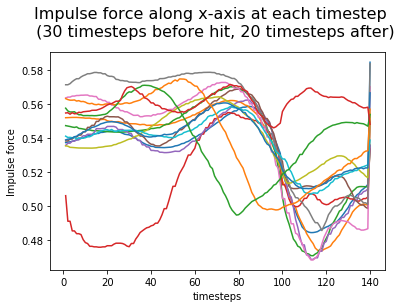

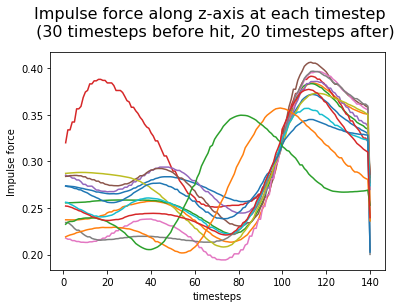

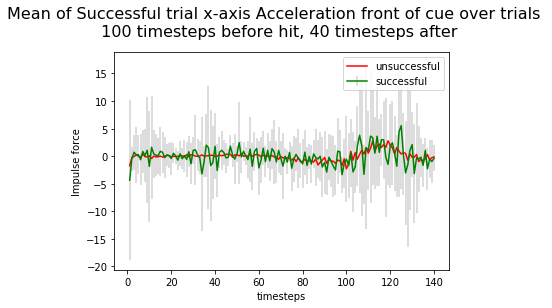

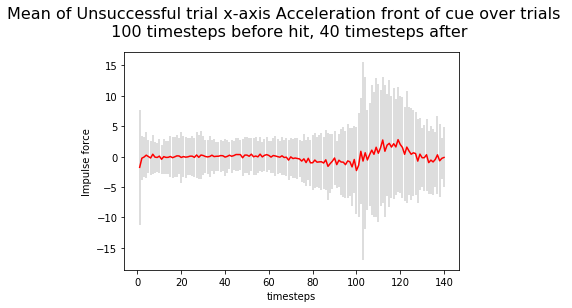

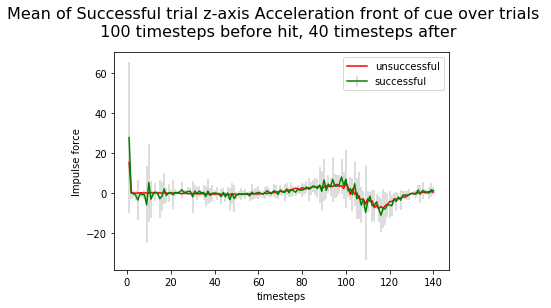

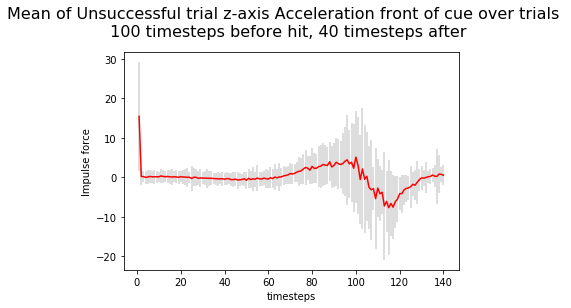

In [ ]:
# Read Saved dataset

successful_rewards_ind = []
for i in range(len(rewards)):
        if terminals.iloc[i] == True:
                if rewards.iloc[i] != -10.0:
                        successful_rewards_ind = np.append(successful_rewards_ind, i)
successful_trial_list = trial.iloc[successful_rewards_ind]


fig1, action_pattern_x = plt.subplots()
fig2, action_pattern_z = plt.subplots()

for i in successful_trial_list:
        action_pattern_x.plot(np.arange(1, len(actions[trial == i])+1), actions[trial == i][0])
        action_pattern_z.plot(np.arange(1, len(actions[trial == i])+1), actions[trial == i][2])

action_pattern_x.set_xlabel("timesteps")
action_pattern_x.set_ylabel("Impulse force")
fig1.suptitle('Impulse force along x-axis at each timestep \n (30 timesteps before hit, 20 timesteps after)', fontsize=16, y=1.04)
action_pattern_z.set_xlabel("timesteps")
action_pattern_z.set_ylabel("Impulse force")
fig2.suptitle('Impulse force along z-axis at each timestep \n (30 timesteps before hit, 20 timesteps after)', fontsize=16, y=1.04)



#unsuccessful_trial_list = trial.drop(a.index, axis=0)
successful_actions = actions.iloc[successful_trial_list.index]

#unsuccessful_actions = actions.iloc[unsuccessful_trial_list.index]
#successful_actions = pd.DataFrame(index=range(len(successful_trial_list)*states[trial==1].shape[0]),columns=range(actions.shape[1]))
#unsuccessful_actions = pd.DataFrame(index=range(len(unsuccessful_trial_list)*states[trial==1].shape[0]),columns=range(actions.shape[1]))
"""for i in successful_trial_list:
        successful_actions.iloc[i:i+states[trial==1].shape[0]] = actions[trial==i]
for i in unsuccessful_trial_list:
        unsuccessful_actions.iloc[i:i+states[trial==1].shape[0]]  = actions[trial==i]"""

s_a = np.zeros((len(successful_actions), states[trial==1].shape[0], actions.shape[1]))  #trial 1 is always complete (250 elements)
u_a = np.zeros((len(trial.unique())-len(successful_actions), states[trial==1].shape[0], actions.shape[1]))
j = 0
k = 0
print("a shape: ", actions.shape[1])

episode_len = states[trial==1].shape[0]
for i, trial_ind in enumerate(trial.unique()):
        pad_len = episode_len - actions[trial==trial_ind].shape[0]
        a = actions[trial==trial_ind]
        if np.isin(trial_ind, successful_trial_list):
                if pad_len > 0:
                        print("pad successful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan)

                s_a[j][:][:] = a
                j+=1
        else:
                if pad_len > 0:
                        print("pad unsuccessful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan) 
                u_a[k][:][:] = a
                k+=1 
print("s_a shape: ", s_a.shape)
s_a = s_a[:,:,[10, 12]]
print("s_a cuevel shape: ", s_a.shape)
print("u_a shape: ", u_a.shape)
u_a = u_a[:,:,[10, 12]]
print("s_a cuevel shape: ", u_a.shape)
successful_mean = np.nanmean(s_a, axis=0, keepdims=True)      #numpy.nanmean()
successful_std = np.nanstd(s_a, axis=0)
unsuccessful_mean = np.nanmean(u_a, axis=0)     #unsuccessful_trial_list
unsuccessful_std = np.nanstd(u_a, axis=0)         #unsuccessful_trial_list

#print(successful_mean.shape[0], successful_mean[:][1])
successful_mean = successful_mean.reshape(-1)
successful_mean = successful_mean.reshape(episode_len,2) #(50,2)
#successful_mean = successful_mean[:,2:4]
unsuccessful_mean = unsuccessful_mean.reshape(-1)
unsuccessful_mean = unsuccessful_mean.reshape(episode_len,2)      #(50,2)


fig3, mean_x = plt.subplots()
#mean_x.plot(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,0])   #linestyle='None', marker='^')
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Impulse force")
fig3.suptitle('Mean of Successful trial x-axis Acceleration front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,0], successful_std[:,0], color='green', ecolor='lightgrey', label='successful')#, linestyle='None', marker='^')
mean_x.plot(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,0],  color='red', label='unsuccessful') 
mean_x.legend()

fig4, mean_x = plt.subplots()
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Impulse force")
fig4.suptitle('Mean of Unsuccessful trial x-axis Acceleration front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,0], unsuccessful_std[:,0], color='red', ecolor='lightgrey')  # linestyle='None', marker='^')

fig5, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig5.suptitle('Mean of Successful trial z-axis Acceleration front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,1], successful_std[:,1], color='green', ecolor='lightgrey', label='successful')     #, linestyle='None', marker='^')
mean_z.plot(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,1], color='red', label='unsuccessful')
mean_z.legend()

fig6, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig6.suptitle('Mean of Unsuccessful trial z-axis Acceleration front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,1], unsuccessful_std[:,1], color='red', ecolor='lightgrey')


#plt.show()


#fig1.savefig('analysis/action_success_vs_unsuccess/'+initial+'_250_action_Succesful_pattern_x.png', bbox_inches='tight')
#fig2.savefig('analysis/action_success_vs_unsuccess/'+initial+'_250_action_Successful_pattern_z.png', bbox_inches='tight')

fig3.savefig('analysis/acceleration/action_success_vs_unsuccess/'+initial+'_action_Successful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')
fig4.savefig('analysis/acceleration/action_success_vs_unsuccess/'+initial+'_action_Unuccessful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')

fig5.savefig('analysis/acceleration/action_success_vs_unsuccess/'+initial+'_action_Successful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')
fig6.savefig('analysis/acceleration/action_success_vs_unsuccess/'+initial+'_action_Unsuccessful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')

"""
actions[trial == 1][0].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))  
"""
"""
g = sns.FacetGrid(df_monthly, col="Year", row="Month", height=4.2, aspect=1.9)
g = g.map(sns.barplot, 'District', 'PM2.5', palette='viridis', ci=None, order = list_district)

g.set_xticklabels(rotation = 90)
plt.show()
"""

### 3D KDE distributions visualisation (for each timestep)

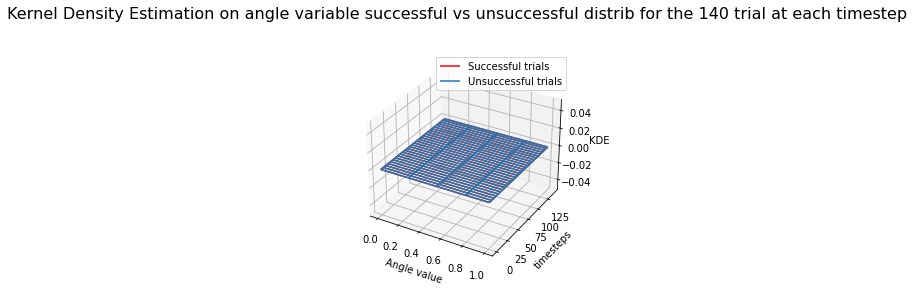

In [ ]:
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def create_kde_plot(successful_actions_list, unsuccessful_actions_list):
    # Create a figure and axis
    #fig, ax = plt.subplots()
    timesteps = 140
    precision = 20
    fig = pl.figure()
    ax = fig.add_subplot(1,1,1,projection='3d')
    fig.suptitle('Kernel Density Estimation on angle variable successful vs unsuccessful distrib for the 140 trial at each timestep', fontsize=16, y=1.04)
    
    Z = np.zeros((timesteps,precision))
    Z_u = np.zeros((timesteps,precision))
    X = np.linspace(0,1,precision)
    Y = np.ones((Z.shape[0], X.shape[0]))
    for timestep in range(timesteps):
        successful_actions = successful_actions_list[:,timestep]
        unsuccessful_actions = unsuccessful_actions_list[:,timestep]
        
        # Create a kernel density estimate plot for successful actions
        #sns.kdeplot(successful_actions, color='blue', ax=ax)
        kde = gaussian_kde(successful_actions)
        Z[timestep] = kde.evaluate(X)
        # Create a kernel density estimate plot for unsuccessful actions
        #sns.kdeplot(unsuccessful_actions, color='red', ax=ax)
        kde_u = gaussian_kde(successful_actions)
        Z_u[timestep] = kde_u.evaluate(X)

        Y[timestep] = (timestep+1)*Y[timestep]
        # Add a title to the plot
        #ax.set_title(f'Timestep {timestep} Action Space Distribution')
        #if timestep >= 84 and timestep <=89:
            #ax.plot(X, Y[timestep], Z[timestep], color='b')
        #else:
            #ax.plot(X, Y[timestep], Z[timestep], color='r')
        #ax.plot(X, Y[timestep], Z[timestep], color='g')
        # Show the plot
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5, color = 'r', label='Successful trials')
    ax.plot_wireframe(X, Y, Z_u, rstride=5, cstride=5, label='Unsuccessful trials')
    ax.set_xlabel("Angle value")
    ax.set_ylabel("timesteps")
    ax.set_zlabel("KDE")
    ax.legend() 
    plt.show()
    fig.savefig('analysis/action_kde/'+initial+'_kde_angle.png', facecolor='w',bbox_inches='tight')



successful_actions_list = s_a[:,:,0]
unsuccessful_actions_list = u_a[:,:,0]
create_kde_plot(successful_actions_list, unsuccessful_actions_list)


### Kernel density estimation of the distribution of successful actions vs unsuccessful action for each timestep

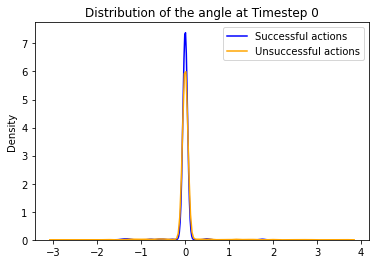

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_kde_plot(timestep, successful_actions, unsuccessful_actions):
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create a kernel density estimate plot for successful actions
    sns.kdeplot(successful_actions, color='blue', ax=ax, label='Successful actions')
    
    # Create a kernel density estimate plot for unsuccessful actions
    sns.kdeplot(unsuccessful_actions, color='orange', ax=ax, label='Unsuccessful actions')
    
    # Add a title to the plot
    ax.set_title(f'Distribution of the angle at Timestep {timestep}')
    
    # Show the plot
    plt.legend(loc='best')
    plt.show()
    fig.savefig('analysis/angle/kde/all-subjects_success-vs-unsuccess_pattern_step_'+str(timestep)+'.png', facecolor='w',bbox_inches='tight')

for timestep in range(0,1):
    successful_actions_list = s_a[:,:,0]
    unsuccessful_actions_list = u_a[:,:,0]
    successful_actions = successful_actions_list[:,timestep]
    unsuccessful_actions = unsuccessful_actions_list[:,timestep]
    create_kde_plot(timestep, successful_actions, unsuccessful_actions)


### t-test for each timestep

shapes:  (23, 140, 2) (226, 140, 2)
shapes:  (23, 140) (23, 140) (226, 140) (226, 140)
140
t-test 100:  2.362812992608102 0.024056504030015705 1.931114322213318 0.0651296687935911
t-test x:  0.7601110406314023 2.8149060861178947 p-values x:  0.009007722561569387 0.4541312099465634
t-test z:  -1.9315088863013636 3.7032941978545364 p-values z:  0.001078032460113453 0.9899059229609898
index max t-test min p value:  41 41


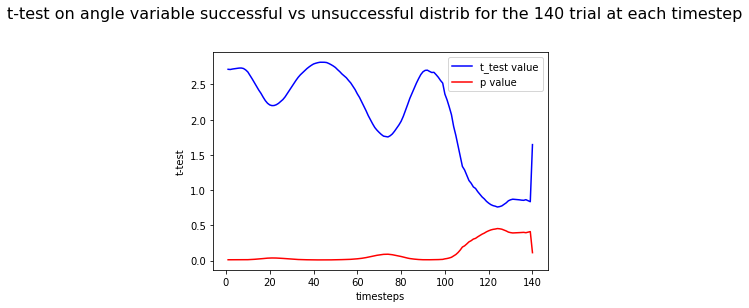

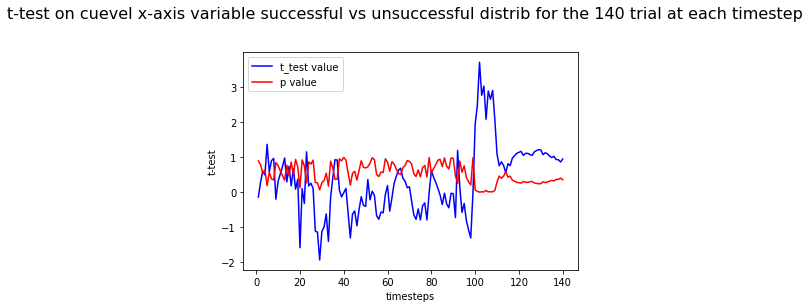

In [ ]:
from scipy.stats import ttest_ind
print("shapes: ", s_a.shape, u_a.shape)
# generate sample data
np.random.seed(0)
successful_actions_x_axis = s_a[:,:,0]    #np.random.normal(0, 1, (250, 100))
successful_actions_z_axis = s_a[:,:,1]  
unsuccessful_actions_x_axis = u_a[:,:,0]# np.random.normal(1, 1, (250, 100))
unsuccessful_actions_z_axis = u_a[:,:,1]
print("shapes: ", successful_actions_x_axis.shape, successful_actions_z_axis.shape, unsuccessful_actions_x_axis.shape, unsuccessful_actions_z_axis.shape)
# calculate t-statistic and p-value for each timestep
t_statistics_x = []
p_values_x = []
t_statistics_z = []
p_values_z = []
print(successful_actions_x_axis.shape[1])
for t in range(successful_actions_x_axis.shape[1]):
    t_statistic_x, p_value_x = ttest_ind(successful_actions_x_axis[:,t], unsuccessful_actions_x_axis[:,t], equal_var = False, nan_policy='omit')
    t_statistics_x.append(t_statistic_x)
    p_values_x.append(p_value_x)

    t_statistic_z, p_value_z = ttest_ind(successful_actions_z_axis[:,t], unsuccessful_actions_z_axis[:,t], equal_var = False, nan_policy='omit')
    t_statistics_z.append(t_statistic_z)
    p_values_z.append(p_value_z)

print("t-test 100: ", t_statistics_x[99], p_values_x[99], t_statistics_z[99], p_values_z[99])
print("t-test x: ", min(t_statistics_x), max(t_statistics_x), "p-values x: ", min(p_values_x),  max(p_values_x))
print("t-test z: ", min(t_statistics_z), max(t_statistics_z), "p-values z: ", min(p_values_z),  max(p_values_z))
print("index max t-test min p value: ", np.asarray(t_statistics_z[60:]).argmax(), np.asarray(p_values_z[60:]).argmin())
fig, ax = plt.subplots()
ax.set_xlabel("timesteps")
ax.set_ylabel("t-test")
fig.suptitle('t-test on angle variable successful vs unsuccessful distrib for the 140 trial at each timestep', fontsize=16, y=1.04)
ax.plot(np.arange(1, successful_actions_x_axis.shape[1]+1), t_statistics_x, color='blue', label='t_test value')
ax.plot(np.arange(1, successful_actions_x_axis.shape[1]+1), p_values_x, color='red', label='p value')
ax.legend() 

fig2, ax2 = plt.subplots()
ax2.set_xlabel("timesteps")
ax2.set_ylabel("t-test")
fig2.suptitle('t-test on cuevel x-axis variable successful vs unsuccessful distrib for the 140 trial at each timestep', fontsize=16, y=1.04)
ax2.plot(np.arange(1, successful_actions_z_axis.shape[1]+1), t_statistics_z, color='blue', label='t_test value')
ax2.plot(np.arange(1, successful_actions_z_axis.shape[1]+1), p_values_z, color='red', label='p value')
ax2.legend() 


#fig.savefig('analysis/action_t-test/'+initial+'_angle.png', facecolor='w',bbox_inches='tight')
#fig2.savefig('analysis/action_t-test/'+initial+'_cuevel_x.png', facecolor='w',bbox_inches='tight')


### Graph Analysis all subjects

In [24]:
path1 = "../data/Round 1/"
path2 = "../data/Round 2/" 
pathlist = [path1, path2]
data_path = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/"#reduced_data/"

filename=[]
#list_pathdir = sorted(os.listdir(data_path))
for path in pathlist:
    for i, initial in enumerate(sorted(os.listdir(path))):
        pathSubj = path + str(initial)
        for fil in range(len(sorted(os.listdir(pathSubj + '/Game/')))):
            if sorted(os.listdir(pathSubj + '/Game/'))[fil].find("Block2") > -1:
                blockFile = sorted(os.listdir(pathSubj + '/Game/'))[fil]

                if blockFile.find('Reward') > -1:
                    if blockFile.find('Left') > -1:
                        filename.append(data_path+initial+"_Offline_reduced.csv")

In [25]:
#path = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/"
#filename = []
#for file in sorted(os.listdir(path)):
	#filename.append(path+file)

df = pd.read_csv(filename[0], header = 0, \
			names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 

states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
actions = pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
terminals = df['terminals'].astype(bool)
rewards = df['rewards'].astype(float)

trials = np.append(trial.unique()[0:75],trial.unique()[225:])
trial_ind = trial.isin(trials)

dataset = {'trial': trial[trial_ind],
				'states': states[trial_ind],
				'actions': actions[trial_ind],
				'new_states': new_states[trial_ind],
				'rewards': rewards[trial_ind],
				'terminals': terminals[trial_ind]}

### If multiple files are passed ###
if len(filename) > 1:
	print(len(filename))
	for i, file in enumerate(filename):
		print(i, file)
		if i > 0:
			df = pd.read_csv(file, header = 0, \
					names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
			df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 
			print(df['states'].str)
			states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
			actions = pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
			new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
			trial = df['trial'].astype(int)
			terminals = df['terminals'].astype(bool)
			rewards = df['rewards'].astype(float)
			
			trials = np.append(trial.unique()[0:75],trial.unique()[225:])
			trial_ind = trial.isin(trials)

			dataset['trial'] = pd.concat([dataset['trial'],trial[trial_ind]+ (i)*250 ], axis=0)
			dataset['states'] = pd.concat([dataset['states'], states[trial_ind]], axis=0)
			dataset['actions'] = pd.concat([dataset['actions'], actions[trial_ind]], axis=0)
			dataset['new_states'] = pd.concat([dataset['new_states'], new_states[trial_ind]], axis=0)
			dataset['rewards'] = pd.concat([dataset['rewards'], rewards[trial_ind]], axis=0)
			dataset['terminals'] = pd.concat([dataset['terminals'], terminals[trial_ind]], axis=0)

20
0 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/AAB_Offline_reduced.csv
1 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/BL_Offline_reduced.csv
2 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/CP_Offline_reduced.csv
3 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/GS_Offline_reduced.csv
4 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/HZ_Offline_reduced.csv
5 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/MAI_Offline_reduced.csv
6 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/MG_Offline_reduced.csv
7 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/MO_Offline_reduced.csv
8 /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/TD3_BC/RL_dataset/Offline_reduced/SC_Offline_reduced.csv
9 /mn

In [26]:
rewards = dataset['rewards']
terminals = dataset['terminals']
trial = dataset['trial']
states = dataset['states']
actions = dataset['actions']

In [ ]:
print(actions)

                0         1
0      103.495414  0.398393
1      103.388062  0.398393
2      103.302020  0.398393
3      103.252180  0.402040
4      103.227787  0.398393
...           ...       ...
34854  103.317624  0.186730
34855  103.214492  0.186730
34856  103.131410  0.087943
34857  103.050427  0.104202
34858  103.002664  0.074408

[271432 rows x 2 columns]


357
140 140
(1, 140, 2)


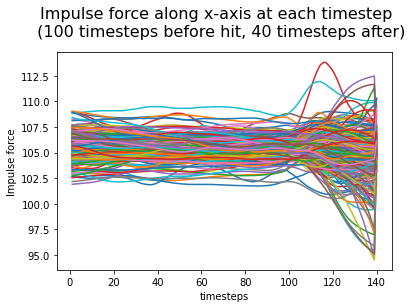

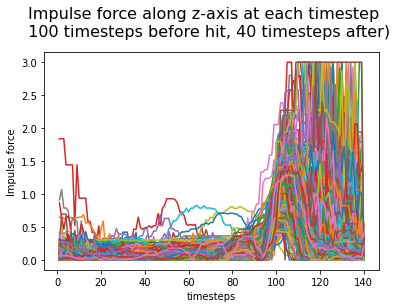

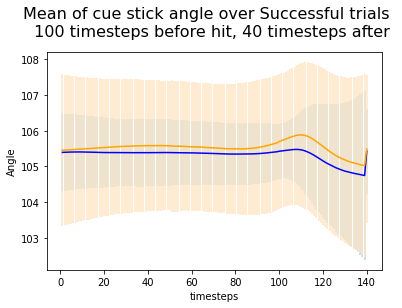

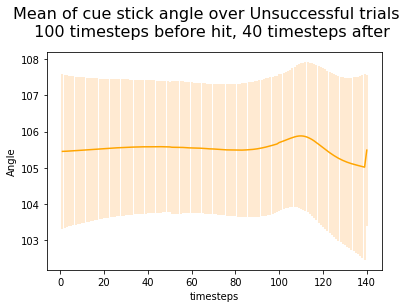

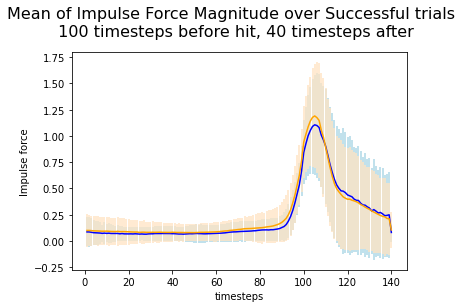

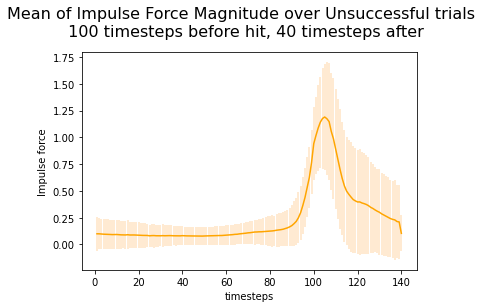

"\nfig1.savefig('analysis/'+initial+'_30_action_Succesful_pattern_x.png', bbox_inches='tight')\nfig2.savefig('analysis/'+initial+'_30_action_Successful_pattern_z.png', bbox_inches='tight')\n\nfig3.savefig('analysis/'+initial+'_30_action_Successful_pattern_mean_x.png', facecolor='w',bbox_inches='tight')\nfig4.savefig('analysis/'+initial+'_30_action_Unuccessful_pattern_mean_x.png', facecolor='w',bbox_inches='tight')\n\nfig5.savefig('analysis/'+initial+'_30_action_Successful_pattern_mean_z.png', facecolor='w',bbox_inches='tight')\nfig6.savefig('analysis/'+initial+'_30_action_Unsuccessful_pattern_mean_z.png', facecolor='w',bbox_inches='tight')"

In [27]:
# Read Saved dataset
#for i in np.array(trial.unique()):
'''
ind = actions[terminals == True]
for i in ind.index:
        print("rewards terminal state: ", rewards[i])
print("reward ind.index[12]: ", rewards[ind.index[12]])
a = ind[rewards != -10.0]
successful_trial_list = trial[a.index]
'''
"""
terminal_rewards = test_set['rewards'][test_set['terminals'] == True]
successful_rewards = terminal_rewards[terminal_rewards != -10.0]
successful_trial_list = test_set['trial'].iloc[successful_rewards.index]"""
#terminal_rewards = rewards[terminals == True]

episode_len = 140
successful_rewards_ind = []
for i in range(len(rewards)):
        if terminals.iloc[i] == True:
                if len(actions[trial==trial.iloc[i]]) == episode_len:
                        if rewards.iloc[i] != 0.0:
                                successful_rewards_ind = np.append(successful_rewards_ind, i)

successful_trial_list = trial.iloc[successful_rewards_ind]
print(len(successful_trial_list))
fig1, action_pattern_x = plt.subplots()
fig2, action_pattern_z = plt.subplots()

for i in successful_trial_list:
        action_pattern_x.plot(np.arange(1, len(actions[trial == i])+1), actions[trial == i][0])
        action_pattern_z.plot(np.arange(1, len(actions[trial == i])+1), actions[trial == i][1])

action_pattern_x.set_xlabel("timesteps")
action_pattern_x.set_ylabel("Impulse force")
fig1.suptitle('Impulse force along x-axis at each timestep \n (100 timesteps before hit, 40 timesteps after)', fontsize=16, y=1.04)
action_pattern_z.set_xlabel("timesteps")
action_pattern_z.set_ylabel("Impulse force")
fig2.suptitle('Impulse force along z-axis at each timestep \n 100 timesteps before hit, 40 timesteps after)', fontsize=16, y=1.04)


#unsuccessful_trial_list = trial.drop(a.index, axis=0)
successful_actions = np.zeros((len(successful_trial_list), len(actions[trial == 19]), actions[trial==1].shape[1]))
#print("successful action shape: ", actions[trial==1][:].shape)
for i, trial_ind in enumerate(successful_trial_list):
        successful_actions[i][:][:] = actions[trial==trial_ind][:]

s_a = np.zeros((len(successful_actions), episode_len, actions.shape[1]))  #trial 1 is always complete (250 elements)
u_a = np.zeros((len(trial.unique())-len(successful_actions), episode_len, actions.shape[1]))
j = 0
k = 0

print(episode_len,actions[trial==1].shape[0])
for i, trial_ind in enumerate(trial.unique()):
        pad_len = episode_len - actions[trial==trial_ind].shape[0]
        if np.isin(trial_ind, successful_trial_list):
                a = actions[trial==trial_ind]   # actions.iloc[i*episode_len:(i+1)*episode_len][:]
                if pad_len > 0:
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan)
                elif pad_len < 0:
                        a = actions.iloc[i*episode_len:(i+1)*episode_len][:]
                s_a[j][:][:] = a
                j+=1
        else:
                a = actions[trial==trial_ind]   #actions.iloc[i*episode_len:(i+1)*episode_len][:]
                if pad_len > 0:
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan) 
                elif pad_len < 0:
                        a = actions.iloc[i*episode_len:(i+1)*episode_len][:]
                u_a[k][:][:] = a
                k+=1 
successful_mean = np.nanmean(s_a, axis=0, keepdims=True)      #numpy.nanmean()
successful_std = np.nanstd(s_a, axis=0)
unsuccessful_mean = np.nanmean(u_a, axis=0)     #unsuccessful_trial_list
unsuccessful_std = np.nanstd(u_a, axis=0)         #unsuccessful_trial_list

print(successful_mean.shape)
#print(successful_mean.shape[0], successful_mean[:][1])
successful_mean = successful_mean.reshape(-1)
successful_mean = successful_mean.reshape(episode_len,2)

unsuccessful_mean = unsuccessful_mean.reshape(-1)
unsuccessful_mean = unsuccessful_mean.reshape(episode_len,2)


fig3, mean_x = plt.subplots()
#mean_x.plot(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,0])   #linestyle='None', marker='^')
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Angle")
fig3.suptitle('Mean of cue stick angle over Successful trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, episode_len+1), successful_mean[:,0], successful_std[:,0], color='blue', ecolor='lightblue')#, linestyle='None', marker='^')
mean_x.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,0], unsuccessful_std[:,0], color='orange', ecolor='bisque')

fig4, mean_x = plt.subplots()
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Angle")
fig4.suptitle('Mean of cue stick angle over Unsuccessful trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,0], unsuccessful_std[:,0], color='orange', ecolor='bisque')  # linestyle='None', marker='^')

fig5, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig5.suptitle('Mean of Impulse Force Magnitude over Successful trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, episode_len+1), successful_mean[:,1], successful_std[:,1], color='blue', ecolor='lightblue')     #, linestyle='None', marker='^')
mean_z.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,1], unsuccessful_std[:,1], color='orange', ecolor='bisque')

fig6, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig6.suptitle('Mean of Impulse Force Magnitude over Unsuccessful trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,1], unsuccessful_std[:,1], color='orange', ecolor='bisque')


plt.show()

"""
fig1.savefig('analysis/'+initial+'_30_action_Succesful_pattern_x.png', bbox_inches='tight')
fig2.savefig('analysis/'+initial+'_30_action_Successful_pattern_z.png', bbox_inches='tight')

fig3.savefig('analysis/'+initial+'_30_action_Successful_pattern_mean_x.png', facecolor='w',bbox_inches='tight')
fig4.savefig('analysis/'+initial+'_30_action_Unuccessful_pattern_mean_x.png', facecolor='w',bbox_inches='tight')

fig5.savefig('analysis/'+initial+'_30_action_Successful_pattern_mean_z.png', facecolor='w',bbox_inches='tight')
fig6.savefig('analysis/'+initial+'_30_action_Unsuccessful_pattern_mean_z.png', facecolor='w',bbox_inches='tight')"""


In [31]:
from scipy.stats import ttest_ind
print("shapes: ", s_a.shape, u_a.shape)
successful_actions_x_axis = s_a[:,:,0]    #np.random.normal(0, 1, (250, 100))
successful_actions_z_axis = s_a[:,:,1]  
unsuccessful_actions_x_axis = u_a[:,:,0]# np.random.normal(1, 1, (250, 100))
unsuccessful_actions_z_axis = u_a[:,:,1]
print("shapes: ", successful_actions_x_axis.shape, successful_actions_z_axis.shape, unsuccessful_actions_x_axis.shape, unsuccessful_actions_z_axis.shape)
# calculate t-statistic and p-value for each timestep
t_statistics_x = []
p_values_x = []
t_statistics_z = []
p_values_z = []
print(successful_actions_x_axis.shape[1])
for t in range(95,105):
    t_statistic_x, p_value_x = ttest_ind(unsuccessful_actions_x_axis[:,t], successful_actions_x_axis[:,t],equal_var = False, nan_policy='omit')
    t_statistics_x.append(t_statistic_x)
    p_values_x.append(p_value_x)

    t_statistic_z, p_value_z = ttest_ind(unsuccessful_actions_z_axis[:,t], successful_actions_z_axis[:,t] , equal_var = False, nan_policy='omit')
    t_statistics_z.append(t_statistic_z)
    p_values_z.append(p_value_z)

print("t-test 100: ", t_statistics_x, p_values_x, t_statistics_z, p_values_z)
print("t-test x: ", min(t_statistics_x), max(t_statistics_x), "p-values x: ", min(p_values_x),  max(p_values_x))
print("t-test z: ", min(t_statistics_z), max(t_statistics_z), "p-values z: ", min(p_values_z),  max(p_values_z))
#print("index max t-test min p value: ", np.asarray(t_statistics_z[60:]).argmax(), np.asarray(p_values_z[60:]).argmin())

shapes:  (357, 140, 2) (1620, 140, 2)
shapes:  (357, 140) (357, 140) (1620, 140) (1620, 140)
140
t-test 100:  [3.404128246433045, 3.569783766578213, 3.7427469742445534, 3.952492038440281, 4.395576121109522, 4.61439393098559, 4.83615398342597, 5.061020966122261, 5.259006695693693, 5.38875566964988] [0.0006838213137654381, 0.00037004400830858606, 0.00018972921183224814, 8.133145556436722e-05, 1.1896510128303746e-05, 4.3090867649334665e-06, 1.473146012514614e-06, 4.7447313744139446e-07, 1.6881998685437143e-07, 8.448756837179952e-08] [6.062810443618763, 6.881976903568928, 6.989715214998124, 6.83043394574423, 5.411926043993086, 4.414891773124798, 3.724772657174428, 3.6854472058123204, 3.2225215890765044, 3.007939640651489] [2.1693655852887406e-09, 1.3069046093452712e-11, 6.550051478205224e-12, 1.9982765079307426e-11, 9.218802000783045e-08, 1.2203054661587888e-05, 0.00021618057452100172, 0.00025155747829788976, 0.0013473553796562992, 0.002753105279265779]
t-test x:  3.404128246433045 5.38875

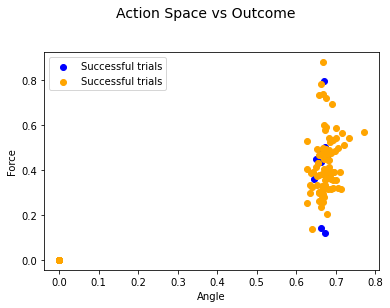

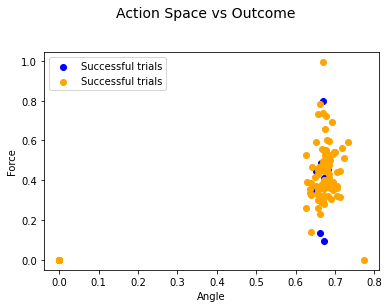

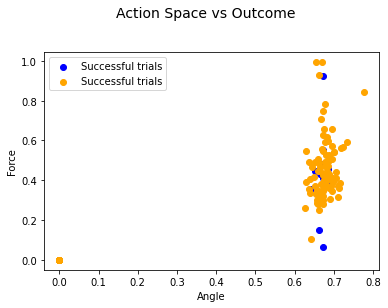

In [ ]:
for timestep in range(99,102):
    #successful_actions_list = s_a[:,:,0]
    #unsuccessful_actions_list = u_a[:,:,0]
    #successful_actions = successful_actions_list[:,timestep]
    #unsuccessful_actions = unsuccessful_actions_list[:,timestep]
    fig3, mean_x = plt.subplots()
    mean_x.set_xlabel("Angle")
    mean_x.set_ylabel("Force")
    fig3.suptitle('Action Space vs Outcome', fontsize=14, y=1.04)
    mean_x.scatter(u_a[:,timestep,0], u_a[:,timestep,1], color='orange', label='Successful trials')
    mean_x.scatter(s_a[:,timestep,0], s_a[:,timestep,1], color='blue', label='Successful trials')
    plt.legend(loc='best')

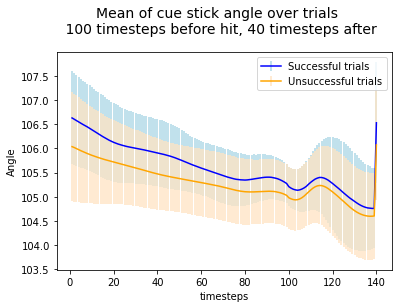

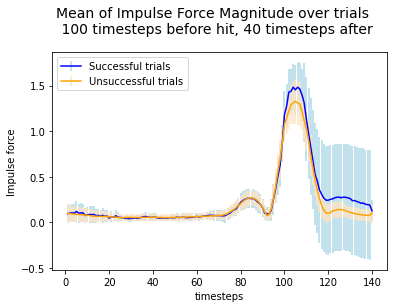

In [ ]:
fig3, mean_x = plt.subplots()
#mean_x.plot(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,0])   #linestyle='None', marker='^')
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Angle")
fig3.suptitle('Mean of cue stick angle over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=14, y=1.04)
mean_x.errorbar(np.arange(1, episode_len+1), successful_mean[:,0], successful_std[:,0], color='blue', ecolor='lightblue', label='Successful trials')#, linestyle='None', marker='^')
mean_x.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,0], unsuccessful_std[:,0], color='orange', ecolor='bisque', label='Unsuccessful trials')
plt.legend(loc='best')
fig5, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig5.suptitle('Mean of Impulse Force Magnitude over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=14, y=1.04)
mean_z.errorbar(np.arange(1, episode_len+1), successful_mean[:,1], successful_std[:,1], color='blue', ecolor='lightblue', label='Successful trials')     #, linestyle='None', marker='^')
mean_z.errorbar(np.arange(1, episode_len+1), unsuccessful_mean[:,1], unsuccessful_std[:,1], color='orange', ecolor='bisque', label='Unsuccessful trials')

plt.legend(loc='best')
fig3.savefig('analysis/angle/all-subjects_success-vs-unsuccess_pattern.png', facecolor='w',bbox_inches='tight')
fig5.savefig('analysis/force/all-subjects_success-vs-unsuccess_pattern.png', facecolor='w',bbox_inches='tight')

### Save Data

In [ ]:
############################# Define Path and Load Dataset ######################################
path = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/"
path2 = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 2/"
initial = "YH"
data = resultsSingleSubject(initial, 'reward', path, "left")
#data1 = resultsMultipleSubjects(path, initial, 'reward', 'all')
#save_raw_data(data, initial)
#save_RL_reduced_dataset(initial)

Result Single Subject function
Success Derivation function
3 fake successes removed


In [ ]:
data1["DR"]["cueballpos"]["trial"][data1["DR"]['start_ind']].unique()

In [ ]:
data['Angle']['Angle']['Trial'][data['Angle']['Angle']['Success'] == 1]


33      34
35      36
36      37
37      38
39      40
40      41
47      48
53      54
57      58
60      61
62      63
70      71
226    227
236    237
238    239
239    240
Name: Trial, dtype: int64

In [ ]:
data['Angle']['Angle']['Trial'][data['Angle']['Angle']['SuccessFunnel'] == 1]

Series([], Name: Trial, dtype: int64)

In [ ]:
def plot_action_animated_learnt_policy(dataset, policy, mean_states, std_states, mean_actions, std_actions, agent="TD3_BC", iteration=44, data_folder=""):

	states,_,_,_,_ = get_trajectory(dataset, dataset["trial"].iloc[iteration])
	fig, ax = plt.subplots(1,1)
	ref_cueposfront = states[:,12:15].cpu().clone().detach()*std_states[12:15] + mean_states[12:15]
	ref_cueposback = states[:,15:18].cpu().clone().detach()*std_states[15:18] + mean_states[15:18]
	cueposfront = np.zeros((states.shape[0],3))
	cueposback = np.zeros((states.shape[0],3))
	cuedirection = np.zeros((states.shape[0],3))
	cueposfront[0][0] = states[0,12]
	cueposfront[0][1] = states[0,13]
	cueposfront[0][2] = states[0,14]
	cueposfront[1][0] = states[1,12]
	cueposfront[1][1] = states[1,13]
	cueposfront[1][2] = states[1,14]
	cueposback[1][0] = states[1,15]
	cueposback[1][1] = states[1,16]
	cueposback[1][2] = states[1,17]
	cuedirection[1][0] = states[1,18] 
	cuedirection[1][1] = states[1,19]
	cuedirection[1][2] = states[1,20]
	angle = np.rad2deg(np.arctan2(cuedirection[1][2], cuedirection[1][0]))
	dt = 0.0111
	cuevel = (cueposfront[1][:]-cueposfront[0][:])/dt
	force = np.linalg.norm(cuevel) 
	if agent == "CQL_SAC":
		actions = policy.select_action(states[1,:], eval=True)
	else:
		actions = policy.select_action(states[1,:])
	
	#vel = [0,0,0]
	for i in range(1, states.shape[0]-1):
		a = actions.detach().numpy()*std_actions + mean_actions
		
		print(actions, a,cueposfront[i][:] , cueposback[i][:], cuedirection[i][:] )
		cueposfront[i+1][:] , cueposback[i+1][:], cuedirection[i+1][:], angle, force = update_cuepos(cueposfront[i][:]*std_states[12:15] + mean_states[12:15], a, angle, force, call="plot")		#, vel, vel)
		#cueposfront[i][:] , cueposback[i][:], vel = update_cuepos(cueposfront[i-1][:],vel, actions)
		#cueposfront2[i][:] = actions[:3]
		#cueposback2[i][:] = actions[3:6]
		#update states
		states[i+1,12] = cueposfront[i+1][0] - mean_states[12] / std_states[12] 
		states[i+1,13] = cueposfront[i+1][1] - mean_states[13] / std_states[13]
		states[i+1,14] = cueposfront[i+1][2] - mean_states[14] / std_states[14]
		states[i+1,15] = cueposback[i+1][0] - mean_states[15] / std_states[15]
		states[i+1,16] = cueposback[i+1][1] - mean_states[16] / std_states[16]
		states[i+1,17] = cueposback[i+1][2] - mean_states[17] / std_states[17]
		states[i+1,18] = cuedirection[i+1][0] - mean_states[18] / std_states[18]
		states[i+1,19] = cuedirection[i+1][1] - mean_states[19] / std_states[19]
		states[i+1,20] = cuedirection[i+1][2] - mean_states[20] / std_states[20]
		#states[i,21] = actions[1]
		#states[i,22] = actions[2]
		#states[i,23] = actions[3]
		if agent == "CQL_SAC":
			actions = policy.select_action(states[i+1,:], eval=True)
		else:
			actions = policy.select_action(states[i+1,:])

	#actions = policy.select_action(states).detach().numpy()
	#cueposfront = actions[:,1:3]
	#cueposback = actions[:,3:5]
	states = states.cpu().detach().numpy()
	cueballpos = np.zeros((states.shape[0],2))
	cueballpos[0][0] = states[0][0]
	cueballpos[0][1] = states[0][2]
	
	def animate(i):
		ax.clear()
		x_ref = [ref_cueposback[i,0], ref_cueposfront[i,0]]
		z_ref = [ref_cueposback[i,2], ref_cueposfront[i,2]]
		ax.plot(x_ref, z_ref, color="green", label = 'reference stick')


		x_values = [cueposback[i][0], cueposfront[i][0]]
		z_values = [cueposback[i][2], cueposfront[i][2]]
		ax.plot(x_values, z_values, color="blue", label = 'Agent cue stick')

		
		"""x_values = [cueposback2[i][0], cueposfront2[i][0]]
		z_values = [cueposback2[i][2], cueposfront2[i][2]]
		ax.plot(x_values, z_values, color="orange", label = 'cue stick pos')"""

		x_val = states[i,0]	*std_states[0] + mean_states[0]
		z_val = states[i,2] *std_states[2] + mean_states[2]
		ax.scatter(x_val, z_val, s=60, facecolors='black', edgecolors='black', label = 'cueball')
		
		ax.scatter(states[i][6]*std_states[6] + mean_states[6], states[i][8]*std_states[8] + mean_states[8], s=60, facecolors='red', edgecolors='red', label = 'target ball')
		ax.scatter(states[i][9]*std_states[9] + mean_states[9], states[i][11]*std_states[11] + mean_states[11], s=200, facecolors='none', edgecolors='green', label = 'pocket')
		ax.set(xlim=(-1, 1), ylim=(-2, 2))
		ax.legend()


	anim = animation.FuncAnimation(fig, animate,  frames = len(states), interval=40, repeat=False)	
	plt.close()
	anim.save('training_plots/'+agent+data_folder+'/iter_'+str(iteration)+'_Agent_learnt_policy.gif', writer='imagemagick')	


In [ ]:
############################# Define Path and Load Dataset ######################################

path = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/"
path2 = "/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 2/"
pathlist = [path, path2]
## WARNING check which type of feedback in which round, and which corner for each subject
#corner =  "left"
#data = resultsSingleSubject(initial, "reward", path, corner)
'''dic for one subject composed of ~1000 timepoints for one shot, 25 shots in one block, and 10 blocks
First 3 blocks are baseline learning, then 6 blocks of adaptation to perturbation, and one final washout block
That is 250 shots per subjects, 300'564 points in the dictionnary'''

# Environment State Properties				
for path in pathlist:
	for i, initial in enumerate(sorted(os.listdir(path))):
		#if initial != "VB" and initial != "WZ" and initial != "YC":
		pathSubj = path + str(initial)
		for fil in range(len(sorted(os.listdir(pathSubj + '/Game/')))):
			if sorted(os.listdir(pathSubj + '/Game/'))[fil].find("Block2") > -1:
				blockFile = sorted(os.listdir(pathSubj + '/Game/'))[fil]
				
				if blockFile.find('Reward') > -1:
					data = resultsMultipleSubjects(path, initial, 'reward', 'all')
					save_raw_data(data, initial)
					#modify_reduced_dataset(initial)
					save_RL_reduced_dataset(initial)


result Multiple Subject function
/mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/ AAB
Result Single Subject function
Success Derivation function
9 fake successes removed
Reward function
start hit timesteps function
Imported AAB as reward subject for Left pocket in round: /mnt/c/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/
reduced raw data  AAB  saved


NameError: name 'Offline_Reduced' is not defined

### Save Raw Data

In [ ]:
def save_raw_data(data, initial):
    reward_ = []
    #rewards = []
    cueballpos = []
    cueballvel = []
    redballpos = []
    targetcornerpos = []
    cueposfront = []
    cueposback = []
    cuedirection = []
    cuevel = []
    radius = 0.005     #real value without margin=0.00027173 #radius is 0.625cm corresponds to around 0.00027173 in VR coordinates
    vertical_margin = 0.01
    total_len_trajectories = 0
    
    k=0
    print(data[initial]["start_ind"].shape[0])
    for i in range(data[initial]["start_ind"].shape[0]):
        #reward_ = []
        for j in range(data[initial]["start_ind"][i], data[initial]["hit_ind"][i]):
            total_len_trajectories += 1
            if j == data[initial]["hit_ind"][i]-1:
                #if i == 12 :
                    #print("right hit index wtf is going on", j, k)
                #done_bool = True
                reward = data[initial]["rewards"][i]
            else:
                #if i == 12:
                    #print("wrong hit index", j, k)
                #done_bool = False
                ## Discounted reward ##
                #gamma = 0.99 
                #reward = gamma**(j - data[initial]["hit_ind"][i]) * data[initial]["rewards"][i]
                #if (data[initial]["cueposfront"]["x"][j]-data[initial]["cueballpos"]["x"][j])**2 + (data[initial]["cueposfront"]["z"][j]-data[initial]["cueballpos"]["z"][j])**2 < radius \
                    #and data[initial]["cueposfront"]["y"][j] < data[initial]["cueballpos"]["y"][j] + vertical_margin:   #cueball radius
                        #reward = 5
                        #print("cue stick touching cueball " , j)
                #else:
                reward = 0.0
            #if i == 12:
                #print(reward)
            #+=1
            reward_.append(reward)
        #rewards.append(np.array(reward_))
        if data[initial]["cueballpos"]["trial"][data[initial]["start_ind"][i]] == 86 or data[initial]["cueballpos"]["trial"][data[initial]["start_ind"][i]]  == 87 or data[initial]["cueballpos"]["trial"][data[initial]["start_ind"][i]]  == 88:
            print(data[initial]["start_ind"][i], data[initial]["hit_ind"][i])

        cueballpos.append(np.array((data[initial]["cueballpos"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballpos"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballpos"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballpos"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        cueballvel.append(np.array((data[initial]["cueballvel"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballvel"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballvel"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueballvel"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        redballpos.append(np.array((data[initial]["redballpos"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["redballpos"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["redballpos"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["redballpos"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        targetcornerpos.append(np.array((data[initial]["targetcornerpos"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["targetcornerpos"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["targetcornerpos"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["targetcornerpos"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        cueposfront.append(np.array((data[initial]["cueposfront"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposfront"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposfront"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposfront"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        cueposback.append(np.array((data[initial]["cueposback"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposback"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposback"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cueposback"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        cuedirection.append(np.array((data[initial]["cuedirection"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuedirection"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuedirection"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuedirection"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))
        cuevel.append(np.array((data[initial]["cuevel"]["trial"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuevel"]["x"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuevel"]["y"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]], data[initial]["cuevel"]["z"][data[initial]["start_ind"][i]:data[initial]["hit_ind"][i]])))

    #for i in range(len(reward_)):
        #print(reward_[i])
    dic = {'rewards': np.array(reward_),    #rewards,  
    'cueballpos': np.zeros(total_len_trajectories, dtype=object),
    'cueballvel': np.zeros(total_len_trajectories, dtype=object),
    'redballpos': np.zeros(total_len_trajectories, dtype=object),
    'targetcornerpos': np.zeros(total_len_trajectories, dtype=object),
    'cueposfront': np.zeros(total_len_trajectories, dtype=object),
    'cueposback': np.zeros(total_len_trajectories, dtype=object),
    'cuedirection': np.zeros(total_len_trajectories, dtype=object),
    'cuevel': np.zeros(total_len_trajectories, dtype=object)}

    transition_num = 0
    #print("cuballpos shape 1: ", cueballpos[1].shape[1], cueballpos[1].shape, data[initial]["start_ind"][1]-data[initial]["hit_ind"][1], rewards[1].shape)
    for i in range(data[initial]["start_ind"].shape[0]):
            for j in range(cueballpos[i].shape[1]):
                    dic['cueballpos'][transition_num] = [cueballpos[i][0][j],cueballpos[i][1][j], cueballpos[i][2][j], cueballpos[i][3][j]]
                    dic['cueballvel'][transition_num] = [cueballvel[i][0][j],cueballvel[i][1][j], cueballvel[i][2][j], cueballvel[i][3][j]]
                    dic['redballpos'][transition_num] = [redballpos[i][0][j], redballpos[i][1][j], redballpos[i][2][j], redballpos[i][3][j]]
                    dic['targetcornerpos'][transition_num] = [targetcornerpos[i][0][j], targetcornerpos[i][1][j], targetcornerpos[i][2][j], targetcornerpos[i][3][j]]
                    dic['cueposfront'][transition_num] = [cueposfront[i][0][j], cueposfront[i][1][j], cueposfront[i][2][j], cueposfront[i][3][j]]
                    dic['cueposback'][transition_num] = [cueposback[i][0][j], cueposback[i][1][j], cueposback[i][2][j], cueposback[i][3][j]]
                    dic['cuedirection'][transition_num] = [cuedirection[i][0][j], cuedirection[i][1][j], cuedirection[i][2][j], cuedirection[i][3][j]]
                    dic['cuevel'][transition_num] = [cuevel[i][0][j], cuevel[i][1][j], cuevel[i][2][j], cuevel[i][3][j]]
                    transition_num += 1

    pd_dataset = pd.DataFrame.from_dict(dic)
    #pd_dataset.to_csv("RL_dataset/reduced_data/"+initial+"_reduced_data.csv")
    #pd_dataset.to_csv("RL_dataset/raw_data/"+initial+"_raw_data.csv")
    #pd_dataset.to_csv("RL_dataset/"+initial+"_raw.csv")
    print("reduced raw data ", initial, " saved")
    return pd_dataset, dic

### Modify reward of reduced data

In [ ]:
def modify_reduced_dataset(initial):
    df = pd.read_csv("RL_dataset/reduced_data/"+initial+"_reduced_data.csv", header = 0, \
        #df = pd.read_csv("RL_dataset/"+initial+"_raw.csv", header = 0, \
                names = ['rewards','cueballpos', 'cueballvel','redballpos', 'targetcornerpos', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel'], usecols = [1,2,3,4,5,6,7,8,9], lineterminator = "\n")
    df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
    rewards= pd.DataFrame.from_records(np.array(df['rewards'].astype(str).str.split(','))).astype(float)
    cueballpos = pd.DataFrame.from_records(np.array(df['cueballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
    cueposfront = pd.DataFrame.from_records(np.array(df['cueposfront'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
    
    reward_ = []
    radius = 0.005     #real value without margin=0.00027173 #radius is 0.625cm corresponds to around 0.00027173 in VR coordinates
    vertical_margin = 0.01
    total_len_trajectories = 0
    
    for i in range(data[initial]["start_ind"].shape[0]):
        for j in range(data[initial]["start_ind"][i], data[initial]["hit_ind"][i]):
            total_len_trajectories += 1
            if j == data[initial]["hit_ind"][i]-1:
                reward = data[initial]["rewards"][i]
            else:
                if (cueposfront["x"][j]-cueballpos["x"][j])**2 + (cueposfront["z"][j]-cueballpos["z"][j])**2 < radius \
                    and cueposfront["y"][j] < cueballpos["y"][j] + vertical_margin:   
                        reward = 5
                else:
                    reward = 0
            reward_.append(reward)
    df['rewards'] = np.array(reward_)

In [ ]:
modify_reduced_dataset("CP")

### Save RL dataset

In [ ]:
def save_RL_reduced_dataset(initial):
        df = pd.read_csv("RL_dataset/reduced_data/"+initial+"_reduced_data.csv", header = 0, \
        #df = pd.read_csv("RL_dataset/"+initial+"_raw.csv", header = 0, \
                names = ['rewards','cueballpos', 'cueballvel','redballpos', 'targetcornerpos', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel'], usecols = [1,2,3,4,5,6,7,8,9], lineterminator = "\n")
        df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
        rewards= pd.DataFrame.from_records(np.array(df['rewards'].astype(str).str.split(','))).astype(float)
        cueballpos = pd.DataFrame.from_records(np.array(df['cueballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueballvel = pd.DataFrame.from_records(np.array(df['cueballvel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        redballpos = pd.DataFrame.from_records(np.array(df['redballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        targetcornerpos = pd.DataFrame.from_records(np.array(df['targetcornerpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueposfront = pd.DataFrame.from_records(np.array(df['cueposfront'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueposback = pd.DataFrame.from_records(np.array(df['cueposback'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cuedirection = pd.DataFrame.from_records(np.array(df['cuedirection'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cuevel = pd.DataFrame.from_records(np.array(df['cuevel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)

        ball_data = {'cueballpos': cueballpos,
             'cueballvel': cueballvel,
            'redballpos': redballpos,
            'targetcornerpos': targetcornerpos
            }
        cue_data = {'cueposfront': cueposfront,
                'cueposback': cueposback,
                'cuedirection': cuedirection    #, 'cuevel': cuevel
                }
        dataset = Offline_Reduced(ball_data, cue_data, cuevel, rewards[0],state_dim=21)
        #dataset = Offline_One(ball_data, cue_data, cuevel, rewards[0])  #rewars[0] to get float value from dataframe
        # Dataframe does not accept 2-d arrays
        # transform 2-d array (n states times 14 dimensions (state)) to 1-d array of list (of length 14)
        #dataset_RL = Offline_RL_dataset(data,rewards,cuedirection, cuevel,cueballpos, terminate_on_end=True)
        #Offline_RL_load(rewards,cueballpos,redballpos, targetcornerpos, cueposfront, cueposback, cuedirection, cuevel, terminate_on_end=True)
        #dataset = Offline_One_big_dict(data, initial)

        new_d = {'trial': dataset["trial"],
                'states': np.zeros(dataset["states"].shape[0], dtype=object),
                'actions': np.zeros(dataset["actions"].shape[0], dtype=object),
                'new_states': np.zeros(dataset["new_states"].shape[0], dtype=object),
                'rewards': dataset["rewards"],
                'terminals': dataset["terminals"]}
        for i in range(dataset["states"].shape[0]):
                new_d['states'][i] = dataset["states"][i][:].tolist()
                new_d['actions'][i] = dataset["actions"][i][:].tolist()
                new_d['new_states'][i] = dataset["new_states"][i][:].tolist()

        pd_dataset = pd.DataFrame.from_dict(new_d)
        pd_dataset.to_csv("RL_dataset/Offline_reduced_2_original/"+initial+"_Offline_reduced.csv")
        #pd_dataset.to_csv("RL_dataset/"+initial+".csv")
        print(initial, "reduced Offline dataset saved")

# Load Data

### Load raw data

In [ ]:
# Read Saved dataset
initial="AAB"
df = pd.read_csv("RL_dataset/reduced_data/"+initial+"_reduced_data.csv", header = 0, \
        names = ['rewards','cueballpos','redballpos', 'targetcornerpos', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel'], usecols = [1,2,3,4,5,6,7,8], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
rewards= pd.DataFrame.from_records(np.array(df['rewards'].astype(str).str.split(','))).astype(float)
cueballpos = pd.DataFrame.from_records(np.array(df['cueballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
redballpos = pd.DataFrame.from_records(np.array(df['redballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
targetcornerpos = pd.DataFrame.from_records(np.array(df['targetcornerpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cueposfront = pd.DataFrame.from_records(np.array(df['cueposfront'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cueposback = pd.DataFrame.from_records(np.array(df['cueposback'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cuedirection = pd.DataFrame.from_records(np.array(df['cuedirection'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cuevel = pd.DataFrame.from_records(np.array(df['cuevel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)

In [ ]:
list_data = {'cueballpos': cueballpos,
             'redballpos': redballpos, 
             'targetcornerpos': targetcornerpos,
             'cueposfront': cueposfront, 
             'cueposback': cueposback,
             'cuedirection': cuedirection,
              'cuevel': cuevel}

### Load RL data

In [ ]:
# Read Saved dataset
initial = "DR"
df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
        names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
actions= pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
#Train/Test split
trial_ind = np.arange(1,len(trial.unique())+1)
train_trial = np.random.choice(trial_ind, size=200, replace=False)  #distrib proba for each value, could be useful to weight more "important" trajectories
test_trial = np.delete(trial_ind, train_trial-1)

train_ind = trial.isin(train_trial)
test_ind = trial.isin(test_trial)

train_set = {'trial': trial[train_ind],
                'states': states[train_ind],
                'actions': actions[train_ind],
                'new_states': new_states[train_ind],
                'rewards': df['rewards'][train_ind],
                'terminals': df['terminals'][train_ind]}

test_set = {'trial': trial[test_ind],
                'states': states[test_ind],
                'actions': actions[test_ind],
                'new_states': new_states[test_ind],
                'rewards': df['rewards'][test_ind],
                'terminals': df['terminals'][test_ind]}

In [ ]:
train_set["actions"].keys()

RangeIndex(start=0, stop=10, step=1)

In [ ]:
def sample(dic):
    ind = np.random.randint(1, 250) 
    return (torch.FloatTensor(dic['states'][dic['trial'] == ind].to_numpy()).to(device), torch.FloatTensor(dic['actions'][dic['trial'] == ind].to_numpy()).to(device), 
            torch.FloatTensor(dic['new_states'][dic['trial'] == ind].to_numpy()).to(device), torch.FloatTensor(dic['rewards'][dic['trial'] == ind].to_numpy()).to(device), 
            torch.Tensor(dic['terminals'][dic['trial'] == ind].to_numpy()).to(device))

In [ ]:
def get_trajectory(dic, ind):
    return (torch.FloatTensor(dic['states'][dic['trial'] == ind].to_numpy()).to(device), torch.FloatTensor(dic['actions'][dic['trial'] == ind].to_numpy()).to(device), 
            torch.FloatTensor(dic['new_states'][dic['trial'] == ind].to_numpy()).to(device), torch.FloatTensor(dic['rewards'][dic['trial'] == ind].to_numpy()).to(device), 
            torch.Tensor(dic['terminals'][dic['trial'] == ind].to_numpy()).to(device))

### Pool Graphic Visualisation

In [ ]:
import matplotlib.animation as animation

states,_,_,_,_ = get_trajectory(train_set, train_set["trial"].iloc[20])
states = states.detach().numpy()
print(len(states))
#cueposfront = policy.select_action(states).detach().numpy()

fig, ax = plt.subplots(1,1)

def animate(i):
	ax.clear()
	#cueposfront = policy.select_action(states)
	#line.set_xdata(cueposfront[i,0].detach().numpy())
	#line.set_ydata(cueposfront[i,1].detach().numpy())  # update the data.
	#line.set_data(cueposfront[i,0].detach().numpy()+i/10, cueposfront[i,1].detach().numpy()+i/10)
	x_values = [states[i,8], states[i,10]]
	z_values = [states[i,9], states[i,11]]
	#line.set_data(x_values, z_values)
	ax.plot(x_values, z_values, color="blue", label = 'cue stick')

	x_val = states[i,0]
	z_val = states[i,1]
	#point.set_data(x_values, z_values)
	ax.scatter(x_val, z_val, s=60, facecolors='black', edgecolors='black', label = 'cueball')
	
	
	ax.scatter(states[i][4], states[i][5], s=60, facecolors='red', edgecolors='red', label = 'target ball')
	ax.scatter(states[i][6], states[i][7], s=400, facecolors='none', edgecolors='green', label = 'pocket')	#label = str(i), 
	ax.set(xlim=(-1, 1), ylim=(-2, 1))
	ax.legend()
	#return line, point,


anim = animation.FuncAnimation(fig, animate,  frames = len(states), interval=20, repeat=False)	#init_func=init, blit=True
plt.close()
#from matplotlib.animation import PillowWriter
anim.save('training_plots/Agent_policy2.gif', writer='imagemagick')	#dpi=300, writer=PillowWriter(fps=1))	#imagemagick
print("saved GIF")

250
saved GIF


## Train Raw dataset and RL dataset

### Raw

In [ ]:
train_set = Offline_RL_dataset(nb_trials=list_data['cueballpos']["trial"].iloc[-1])
train_set.get_trajectories(list_data, rewards)
#train_set.compute_mean_std(list_data)
#train_set.normalize_states()

### RL

In [ ]:
states, actions, new_states, rewards, terminals = sample(train_set)

188


## Evaluation

In [ ]:
evaluations = []
for t in range(int(args["max_timesteps"])):
	policy.train(replay_buffer, args["batch_size"])
	'''
	# Evaluate episode
	if (t + 1) % args["eval_freq"] == 0:
		print(f"Time steps: {t+1}")
		evaluations.append(eval_policy(policy, args.env, args.seed, mean, std))
		#np.save(f"./results/{file_name}", evaluations)
		#if args.save_model: policy.save(f"./models/{file_name}")
	'''

In [ ]:
# Runs policy for X episodes and returns score
# A fixed seed is used for the eval environment
def eval_policy(policy, eval_dataset, mean, std, eval_episodes=2):

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			state = (np.array(state).reshape(1,-1) - mean)/std
			action = policy.select_action(state)
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes
	d4rl_score = eval_env.get_normalized_score(avg_reward) * 100

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}, D4RL score: {d4rl_score:.3f}")
	print("---------------------------------------")
	return d4rl_score

In [ ]:
num_j_steps = 25
gamma = 0.98
mag = MAGIC(gamma)
info = [data.actions(),
                data.rewards(),
                data.base_propensity(),
                data.target_propensity(),
                Qs
                ]
magic_evaluation = mag.evaluate(info, num_j_steps, True)
print(magic_evaluation[0], (magic_evaluation[0] - true )**2)

## Magic

### Counter

In [ ]:

import _collections_abc

def _count_elements(mapping, iterable):
    'Tally elements from the iterable.'
    mapping_get = mapping.get
    for elem in iterable:
        mapping[elem] = mapping_get(elem, 0) + 1
'''
try:                                    # Load C helper function if available
    from _collections import _count_elements
except ImportError:
    pass
'''

class itemgetter:
    """
    Return a callable object that fetches the given item(s) from its operand.
    After f = itemgetter(2), the call f(r) returns r[2].
    After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
    """
    __slots__ = ('_items', '_call')

    def __init__(self, item, *items):
        if not items:
            self._items = (item,)
            def func(obj):
                return obj[item]
            self._call = func
        else:
            self._items = items = (item,) + items
            def func(obj):
                return tuple(obj[i] for i in items)
            self._call = func

    def __call__(self, obj):
        return self._call(obj)

    def __repr__(self):
        return '%s.%s(%s)' % (self.__class__.__module__,
                              self.__class__.__name__,
                              ', '.join(map(repr, self._items)))

    def __reduce__(self):
        return self.__class__, self._items


class Counter(dict):
    '''Dict subclass for counting hashable items.  Sometimes called a bag
    or multiset.  Elements are stored as dictionary keys and their counts
    are stored as dictionary values.
    >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
    >>> c.most_common(3)                # three most common elements
    [('a', 5), ('b', 4), ('c', 3)]
    >>> sorted(c)                       # list all unique elements
    ['a', 'b', 'c', 'd', 'e']
    >>> ''.join(sorted(c.elements()))   # list elements with repetitions
    'aaaaabbbbcccdde'
    >>> sum(c.values())                 # total of all counts
    15
    >>> c['a']                          # count of letter 'a'
    5
    >>> for elem in 'shazam':           # update counts from an iterable
    ...     c[elem] += 1                # by adding 1 to each element's count
    >>> c['a']                          # now there are seven 'a'
    7
    >>> del c['b']                      # remove all 'b'
    >>> c['b']                          # now there are zero 'b'
    0
    >>> d = Counter('simsalabim')       # make another counter
    >>> c.update(d)                     # add in the second counter
    >>> c['a']                          # now there are nine 'a'
    9
    >>> c.clear()                       # empty the counter
    >>> c
    Counter()
    Note:  If a count is set to zero or reduced to zero, it will remain
    in the counter until the entry is deleted or the counter is cleared:
    >>> c = Counter('aaabbc')
    >>> c['b'] -= 2                     # reduce the count of 'b' by two
    >>> c.most_common()                 # 'b' is still in, but its count is zero
    [('a', 3), ('c', 1), ('b', 0)]
    '''
    # References:
    #   http://en.wikipedia.org/wiki/Multiset
    #   http://www.gnu.org/software/smalltalk/manual-base/html_node/Bag.html
    #   http://www.demo2s.com/Tutorial/Cpp/0380__set-multiset/Catalog0380__set-multiset.htm
    #   http://code.activestate.com/recipes/259174/
    #   Knuth, TAOCP Vol. II section 4.6.3

    def __init__(self, iterable=None, /, **kwds):
        '''Create a new, empty Counter object.  And if given, count elements
        from an input iterable.  Or, initialize the count from another mapping
        of elements to their counts.
        >>> c = Counter()                           # a new, empty counter
        >>> c = Counter('gallahad')                 # a new counter from an iterable
        >>> c = Counter({'a': 4, 'b': 2})           # a new counter from a mapping
        >>> c = Counter(a=4, b=2)                   # a new counter from keyword args
        '''
        super().__init__()
        self.update(iterable, **kwds)

    def __missing__(self, key):
        'The count of elements not in the Counter is zero.'
        # Needed so that self[missing_item] does not raise KeyError
        return 0

    def total(self):
        'Sum of the counts'
        return sum(self.values())

    def most_common(self, n=None):
        '''List the n most common elements and their counts from the most
        common to the least.  If n is None, then list all element counts.
        >>> Counter('abracadabra').most_common(3)
        [('a', 5), ('b', 2), ('r', 2)]
        '''
        # Emulate Bag.sortedByCount from Smalltalk
        if n is None:
            return sorted(self.items(), key=_itemgetter(1), reverse=True)

        # Lazy import to speedup Python startup time
        import heapq
        return heapq.nlargest(n, self.items(), key=_itemgetter(1))

    def elements(self):
        '''Iterator over elements repeating each as many times as its count.
        >>> c = Counter('ABCABC')
        >>> sorted(c.elements())
        ['A', 'A', 'B', 'B', 'C', 'C']
        # Knuth's example for prime factors of 1836:  2**2 * 3**3 * 17**1
        >>> import math
        >>> prime_factors = Counter({2: 2, 3: 3, 17: 1})
        >>> math.prod(prime_factors.elements())
        1836
        Note, if an element's count has been set to zero or is a negative
        number, elements() will ignore it.
        '''
        # Emulate Bag.do from Smalltalk and Multiset.begin from C++.
        return _chain.from_iterable(_starmap(_repeat, self.items()))

    # Override dict methods where necessary

    @classmethod
    def fromkeys(cls, iterable, v=None):
        # There is no equivalent method for counters because the semantics
        # would be ambiguous in cases such as Counter.fromkeys('aaabbc', v=2).
        # Initializing counters to zero values isn't necessary because zero
        # is already the default value for counter lookups.  Initializing
        # to one is easily accomplished with Counter(set(iterable)).  For
        # more exotic cases, create a dictionary first using a dictionary
        # comprehension or dict.fromkeys().
        raise NotImplementedError(
            'Counter.fromkeys() is undefined.  Use Counter(iterable) instead.')

    def update(self, iterable=None, /, **kwds):
        '''Like dict.update() but add counts instead of replacing them.
        Source can be an iterable, a dictionary, or another Counter instance.
        >>> c = Counter('which')
        >>> c.update('witch')           # add elements from another iterable
        >>> d = Counter('watch')
        >>> c.update(d)                 # add elements from another counter
        >>> c['h']                      # four 'h' in which, witch, and watch
        4
        '''
        # The regular dict.update() operation makes no sense here because the
        # replace behavior results in the some of original untouched counts
        # being mixed-in with all of the other counts for a mismash that
        # doesn't have a straight-forward interpretation in most counting
        # contexts.  Instead, we implement straight-addition.  Both the inputs
        # and outputs are allowed to contain zero and negative counts.

        if iterable is not None:
            if isinstance(iterable, _collections_abc.Mapping):
                if self:
                    self_get = self.get
                    for elem, count in iterable.items():
                        self[elem] = count + self_get(elem, 0)
                else:
                    # fast path when counter is empty
                    super().update(iterable)
            else:
                _count_elements(self, iterable)
        if kwds:
            self.update(kwds)

    def subtract(self, iterable=None, /, **kwds):
        '''Like dict.update() but subtracts counts instead of replacing them.
        Counts can be reduced below zero.  Both the inputs and outputs are
        allowed to contain zero and negative counts.
        Source can be an iterable, a dictionary, or another Counter instance.
        >>> c = Counter('which')
        >>> c.subtract('witch')             # subtract elements from another iterable
        >>> c.subtract(Counter('watch'))    # subtract elements from another counter
        >>> c['h']                          # 2 in which, minus 1 in witch, minus 1 in watch
        0
        >>> c['w']                          # 1 in which, minus 1 in witch, minus 1 in watch
        -1
        '''
        if iterable is not None:
            self_get = self.get
            if isinstance(iterable, _collections_abc.Mapping):
                for elem, count in iterable.items():
                    self[elem] = self_get(elem, 0) - count
            else:
                for elem in iterable:
                    self[elem] = self_get(elem, 0) - 1
        if kwds:
            self.subtract(kwds)

    def copy(self):
        'Return a shallow copy.'
        return self.__class__(self)

    def __reduce__(self):
        return self.__class__, (dict(self),)

    def __delitem__(self, elem):
        'Like dict.__delitem__() but does not raise KeyError for missing values.'
        if elem in self:
            super().__delitem__(elem)

    def __repr__(self):
        if not self:
            return f'{self.__class__.__name__}()'
        try:
            # dict() preserves the ordering returned by most_common()
            d = dict(self.most_common())
        except TypeError:
            # handle case where values are not orderable
            d = dict(self)
        return f'{self.__class__.__name__}({d!r})'

    def __eq__(self, other):
        'True if all counts agree. Missing counts are treated as zero.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] == other[e] for c in (self, other) for e in c)

    def __ne__(self, other):
        'True if any counts disagree. Missing counts are treated as zero.'
        if not isinstance(other, Counter):
            return NotImplemented
        return not self == other

    def __le__(self, other):
        'True if all counts in self are a subset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] <= other[e] for c in (self, other) for e in c)

    def __lt__(self, other):
        'True if all counts in self are a proper subset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return self <= other and self != other

    def __ge__(self, other):
        'True if all counts in self are a superset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] >= other[e] for c in (self, other) for e in c)

    def __gt__(self, other):
        'True if all counts in self are a proper superset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return self >= other and self != other

    def __add__(self, other):
        '''Add counts from two counters.
        >>> Counter('abbb') + Counter('bcc')
        Counter({'b': 4, 'c': 2, 'a': 1})
        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            newcount = count + other[elem]
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count > 0:
                result[elem] = count
        return result

    def __sub__(self, other):
        ''' Subtract count, but keep only results with positive counts.
        >>> Counter('abbbc') - Counter('bccd')
        Counter({'b': 2, 'a': 1})
        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            newcount = count - other[elem]
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count < 0:
                result[elem] = 0 - count
        return result

    def __or__(self, other):
        '''Union is the maximum of value in either of the input counters.
        >>> Counter('abbb') | Counter('bcc')
        Counter({'b': 3, 'c': 2, 'a': 1})
        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            other_count = other[elem]
            newcount = other_count if count < other_count else count
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count > 0:
                result[elem] = count
        return result

    def __and__(self, other):
        ''' Intersection is the minimum of corresponding counts.
        >>> Counter('abbb') & Counter('bcc')
        Counter({'b': 1})
        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            other_count = other[elem]
            newcount = count if count < other_count else other_count
            if newcount > 0:
                result[elem] = newcount
        return result

    def __pos__(self):
        'Adds an empty counter, effectively stripping negative and zero counts'
        result = Counter()
        for elem, count in self.items():
            if count > 0:
                result[elem] = count
        return result

    def __neg__(self):
        '''Subtracts from an empty counter.  Strips positive and zero counts,
        and flips the sign on negative counts.
        '''
        result = Counter()
        for elem, count in self.items():
            if count < 0:
                result[elem] = 0 - count
        return result

    def _keep_positive(self):
        '''Internal method to strip elements with a negative or zero count'''
        nonpositive = [elem for elem, count in self.items() if not count > 0]
        for elem in nonpositive:
            del self[elem]
        return self

    def __iadd__(self, other):
        '''Inplace add from another counter, keeping only positive counts.
        >>> c = Counter('abbb')
        >>> c += Counter('bcc')
        >>> c
        Counter({'b': 4, 'c': 2, 'a': 1})
        '''
        for elem, count in other.items():
            self[elem] += count
        return self._keep_positive()

    def __isub__(self, other):
        '''Inplace subtract counter, but keep only results with positive counts.
        >>> c = Counter('abbbc')
        >>> c -= Counter('bccd')
        >>> c
        Counter({'b': 2, 'a': 1})
        '''
        for elem, count in other.items():
            self[elem] -= count
        return self._keep_positive()

    def __ior__(self, other):
        '''Inplace union is the maximum of value from either counter.
        >>> c = Counter('abbb')
        >>> c |= Counter('bcc')
        >>> c
        Counter({'b': 3, 'c': 2, 'a': 1})
        '''
        for elem, other_count in other.items():
            count = self[elem]
            if other_count > count:
                self[elem] = other_count
        return self._keep_positive()

    def __iand__(self, other):
        '''Inplace intersection is the minimum of corresponding counts.
        >>> c = Counter('abbb')
        >>> c &= Counter('bcc')
        >>> c
        Counter({'b': 1})
        '''
        for elem, count in self.items():
            other_count = other[elem]
            if other_count < count:
                self[elem] = other_count
        return self._keep_positive()


### Get Qs

In [ ]:
from tqdm import trange

class getQs(object):
	def __init__(self, data, pi_e, processor, action_space_dim = 3):
		self.data = data
		self.pi_e = pi_e
		self.processor = processor
		self.action_space_dim = action_space_dim

	def get(self, model):
		Qs = []
		batchsize = 1
		num_batches = int(np.ceil(len(self.data)/batchsize))
		# frames = np.array([x['frames'] for x in self.trajectories])
		for batchnum in trange(num_batches, desc='Batch'):
			low_ = batchsize*batchnum
			high_ = min(batchsize*(batchnum+1), len(self.data))

			pos = self.data.states(False, low_=low_,high_=high_)
			acts = self.data.actions()[low_:high_]


			# episodes = self.trajectories[low_:high_]
			# pos = np.vstack([np.vstack(x['x']) for x in episodes])
			# N = np.hstack([[low_ + n]*len(x['x']) for n,x in enumerate(episodes)])
			# acts = np.hstack([x['a'] for x in episodes])
			# pos = np.array([np.array(frames[int(N[idx])])[pos[idx].astype(int)] for idx in range(len(pos))])
			traj_Qs = model.Q(self.pi_e, self.processor(pos))

			traj_Qs = traj_Qs.reshape(-1, self.action_space_dim)
			# lengths = self.data.lengths()

			# endpts = np.cumsum(np.hstack([[0], lengths]))
			# for start,end in zip(endpts[:-1], endpts[1:]):
			# 	Qs.append(traj_Qs[start:end])
			Qs.append(traj_Qs)

		return Qs

### Default CNN

In [ ]:
class defaultCNN(nn.Module):
    def __init__(self, shape, action_space_dim):
        super(defaultCNN, self).__init__()
        self.c, self.h, self.w = shape

        self.net = nn.Sequential(
            nn.Conv2d(self.c, 16, (2,2)),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*(self.h-1)*(self.w-1), 8),
            nn.ELU(),
            nn.Linear(8, 8),
            nn.ELU(),
            nn.Linear(8, action_space_dim)
        )
    
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, mean=0.0, std=.001)
            torch.nn.init.normal_(m.bias, mean=0.0, std=.001)

    def forward(self, state, action):
        output = self.net(state)
        return torch.masked_select(output, action)
    
    def predict(self, state):
        return self.net(state)
    
    def predict_w_softmax(self, state):
        return nn.Softmax()(self.net(state))

class defaultModelBasedCNN(nn.Module):
    def __init__(self, shape, action_space_dim):
        super(defaultModelBasedCNN, self).__init__()
        self.c, self.h, self.w = shape

        self.features = nn.Sequential(
            nn.Conv2d(self.c, 4, (5, 5)),
            nn.ELU(),
            nn.Conv2d(4, 8, (3, 3)),
        )

        self.states_head = nn.Sequential(
            nn.ConvTranspose2d(8, 16, (3, 3)),
            nn.ELU(),
            nn.ConvTranspose2d(16, action_space_dim, (5, 5)),
        )
        
        self.rewards_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*(self.h-4-2)*(self.w-4-2), 8),
            nn.ELU(),
            nn.Linear(8, action_space_dim),
        )

        self.dones_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*(self.h-4-2)*(self.w-4-2), 8),
            nn.ELU(),
            nn.Linear(8, action_space_dim),
            nn.Sigmoid()
        )
    
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, mean=0.0, std=.001)
            torch.nn.init.normal_(m.bias, mean=0.0, std=.001)

    def forward(self, state, action):
        T, R, D = self.states_head(self.features(state)), self.rewards_head(self.features(state)), self.dones_head(self.features(state))
        return T[np.arange(len(action)), action.float().argmax(1), ...][:,None,:,:], torch.masked_select(R, action), torch.masked_select(D, action)
    
    def predict(self, state):
        return self.states_head(self.features(state)), self.rewards_head(self.features(state)), self.dones_head(self.features(state))

### Propensity

In [ ]:
class PropensityModel(nn.Module):
    def __init__(self, state_dim, action_dim, std):
        super(PropensityModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.std = std
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def sample(self, x):
        # Sample from the Gaussian distribution with mean predicted by the model and fixed standard deviation
        mean = self.forward(x)
        std = torch.tensor(self.std).expand_as(mean)
        return torch.normal(mean, std)

# Define the model
state_dim = 14  #np.zeros(14)  #np.zeros(21)
action_dim = 2  #np.zeros(2)
model = PropensityModel(state_dim, action_dim, std=0.1)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop through the dataset and update the model
batch_size = 64
for i in range(5000):
    state, action, new_state, reward, not_done = replay_buffer.sample(batch_size)
    
    # Clear the gradients
    optimizer.zero_grad()
    
    # Compute the loss and backpropagate
    loss = criterion(model(state), action)
    loss.backward()
    
    # Update the model parameters
    optimizer.step()

In [ ]:
class PropensityModel(nn.Module):
    def __init__(self, state_dim, action_dim, std):
        super(PropensityModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.std = std
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def sample(self, x):
        # Sample from the Gaussian distribution with mean predicted by the model and fixed standard deviation
        mean = self.forward(x)
        std = torch.tensor(self.std).expand_as(mean)
        return torch.normal(mean, std)

# Define the model
state_dim = 14  #np.zeros(14)  #np.zeros(21)
action_dim = 2  #np.zeros(2)
model = PropensityModel(state_dim, action_dim, std=0.1)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop through the dataset and update the model
batch_size = 64
for i in range(5000):
    state, action, new_state, reward, not_done = replay_buffer.sample(batch_size)

    # Clear the gradients
    optimizer.zero_grad()
    
    # Compute the loss and backpropagate
    loss = criterion(model(state), action)
    loss.backward()
    
    # Update the model parameters
    optimizer.step()

In [ ]:
class PropensityModel(nn.Module):
    def __init__(self, state_dim, action_dim, std=1.0):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.std = std

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        return self.forward(x).numpy()
    
    def log_prob(self, x, actions):
        means = self.forward(x)
        log_prstate = -0.5 * ((actions - means) / self.std) ** 2 - 0.5 * np.log(2 * np.pi) - np.log(self.std)
        return log_prstate.sum(1, keepdim=True)

# Create the model
state_dim = 14  #np.zeros(14)  #np.zeros(21)
action_dim = 2  #np.zeros(2)
model = PropensityModel(state_dim=state_dim, action_dim=action_dim)

# Define a loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Loop over the data and update the model
batch_size = 64
for i in range(5000):
    state, action, new_state, reward, not_done = replay_buffer.sample(batch_size)

    # Compute the log probabilities of the actions
    log_prstate = model.log_prob(state, action)
    
    # Calculate the loss
    loss = -log_prstate.mean()
    
    # Perform backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Use the model to predict the propensity of an action given a state
#state = np.array([[1, 2, 3, 4]])
#print(model.predict(torch.from_numpy(state).float()))

In [ ]:
def estimate_propensity(self, behavior_data):    #cfg):
    # WARN: Only works in tabular env with discrete action space. Current implementation is a max likelihood

    model = defaultCNN(self.states()[0][0].shape, self.n_actions) #cfg.to_regress_pi_b['model']
    optimizer = optim.Adam(model.parameters())

    self.processed_data = self.fill()

    batch_size = 32 #cfg.to_regress_pi_b['batch_size']
    dataset_length = self.num_tuples()
    perm = np.random.permutation(range(dataset_length))
    eighty_percent_of_set = int(.8*len(perm))
    training_idxs = perm[:eighty_percent_of_set]
    validation_idxs = perm[eighty_percent_of_set:]
    training_steps_per_epoch = int(np.ceil(len(training_idxs)/float(batch_size)))
    validation_steps_per_epoch = int(np.ceil(len(validation_idxs)/float(batch_size)))

    for k in tqdm(range(100)):#cfg.to_regress_pi_b['max_epochs']
        
        train_gen = self.generator(training_idxs, fixed_permutation=True, batch_size=batch_size)
        val_gen = self.generator(validation_idxs, fixed_permutation=True, batch_size=batch_size)

        # TODO: earlyStopping, LR reduction

        for step in range(training_steps_per_epoch):
            
            with torch.no_grad():
                (inp, out) = next(train_gen)
                states = torch.from_numpy(inp).float()
                actions = torch.from_numpy(out).float().argmax(1)

            prediction = model.predict_w_softmax(states)
            
            loss = nn.NLLLoss()(torch.log(prediction), actions)
                                        
            optimizer.zero_grad()
            loss.backward()

            clip_grad_norm_(model.parameters(), 1.0)   #cfg.to_regress_pi_b['clipnorm']
            optimizer.step()

    for episode_num, states in enumerate(np.squeeze(self.states())):
        base_propensity = []
        for state in states:
            base_propensity.append(model.predict_w_softmax(torch.from_numpy(state[None,None,...]).float()).detach().numpy()[0].tolist())

        self.trajectories[episode_num]['base_propensity'] = base_propensity


### MAGIC algo

In [ ]:
def omega(self):
        return np.array([[episode['target_propensity'][idx][int(act)]/episode['base_propensity'][idx][int(act)] for idx,act in enumerate(episode['a'])] for episode in self.trajectories])

In [ ]:
class MAGIC(object):
    """Algorithm: MAGIC.
    """
    NUM_SUBSETS_FOR_CB_ESTIMATES = 25
    CONFIDENCE_INTERVAL = 0.9
    NUM_BOOTSTRAP_SAMPLES = 50
    BOOTSTRAP_SAMPLE_PCT = 0.5

    def __init__(self, gamma):
        """
        Parameters
        ----------
        gamma : float
            Discount factor.
        """
        self.gamma = gamma

    def evaluate(self, info, num_j_steps, is_wdr, return_Qs = False):
        """Get MAGIC estimate from Q + IPS.
        Parameters
        ----------
        info : list
            [list of actions, list of rewards, list of base propensity, list of target propensity, list of Qhat]
        num_j_steps : int
            Parameter to MAGIC algorithm
        is_wdr : bool
            Use Weighted Doubly Robust?
        return_Qs : bool
            Return trajectory-wise estimate alongside full DR estimate?
            Default: False
        
        Returns
        -------
        list
            [MAGIC estimate, normalized MAGIC, std error, normalized std error]
            If return_Qs is true, also returns trajectory-wise estimate
        """

        (actions,
        rewards,
        base_propensity,
        target_propensities,
        estimated_q_values) = MAGIC.transform_to_equal_length_trajectories(*info)

        num_trajectories = actions.shape[0]
        trajectory_length = actions.shape[1]

        j_steps = [float("inf")]

        if num_j_steps > 1:
            j_steps.append(-1)
        if num_j_steps > 2:
            interval = trajectory_length // (num_j_steps - 1)
            j_steps.extend([i * interval for i in range(1, num_j_steps - 1)])

        base_propensity_for_logged_action = np.sum(
            np.multiply(base_propensity, actions), axis=2
        )
        target_propensity_for_logged_action = np.sum(
            np.multiply(target_propensities, actions), axis=2
        )
        estimated_q_values_for_logged_action = np.sum(
            np.multiply(estimated_q_values, actions), axis=2
        )
        estimated_state_values = np.sum(
            np.multiply(target_propensities, estimated_q_values), axis=2
        )

        importance_weights = target_propensity_for_logged_action / base_propensity_for_logged_action
        importance_weights[np.isnan(importance_weights)] = 0.
        importance_weights = np.cumprod(importance_weights, axis=1)
        importance_weights = MAGIC.normalize_importance_weights(
            importance_weights, is_wdr
        )

        importance_weights_one_earlier = (
            np.ones([num_trajectories, 1]) * 1.0 / num_trajectories
        )
        importance_weights_one_earlier = np.hstack(
            [importance_weights_one_earlier, importance_weights[:, :-1]]
        )

        discounts = np.logspace(
            start=0, stop=trajectory_length - 1, num=trajectory_length, base=self.gamma
        )

        j_step_return_trajectories = []
        for j_step in j_steps:
            j_step_return_trajectories.append(
                MAGIC.calculate_step_return(
                    rewards,
                    discounts,
                    importance_weights,
                    importance_weights_one_earlier,
                    estimated_state_values,
                    estimated_q_values_for_logged_action,
                    j_step,
                )
            )
        j_step_return_trajectories = np.array(j_step_return_trajectories)

        j_step_returns = np.sum(j_step_return_trajectories, axis=1)

        if len(j_step_returns) == 1:
            weighted_doubly_robust = j_step_returns[0]
            weighted_doubly_robust_std_error = 0.0
        else:
            # break trajectories into several subsets to estimate confidence bounds
            infinite_step_returns = []
            num_subsets = int(
                min(
                    num_trajectories / 2,
                    MAGIC.NUM_SUBSETS_FOR_CB_ESTIMATES,
                )
            )
            interval = num_trajectories / num_subsets
            for i in range(num_subsets):
                trajectory_subset = np.arange(
                    int(i * interval), int((i + 1) * interval)
                )
                importance_weights = (
                    target_propensity_for_logged_action[trajectory_subset]
                    / base_propensity_for_logged_action[trajectory_subset]
                )
                importance_weights[np.isnan(importance_weights)] = 0.
                importance_weights = np.cumprod(importance_weights, axis=1)
                importance_weights = MAGIC.normalize_importance_weights(
                    importance_weights, is_wdr
                )
                importance_weights_one_earlier = (
                    np.ones([len(trajectory_subset), 1]) * 1.0 / len(trajectory_subset)
                )
                importance_weights_one_earlier = np.hstack(
                    [importance_weights_one_earlier, importance_weights[:, :-1]]
                )
                infinite_step_return = np.sum(
                    MAGIC.calculate_step_return(
                        rewards[trajectory_subset],
                        discounts,
                        importance_weights,
                        importance_weights_one_earlier,
                        estimated_state_values[trajectory_subset],
                        estimated_q_values_for_logged_action[trajectory_subset],
                        float("inf"),
                    )
                )
                infinite_step_returns.append(infinite_step_return)

            # Compute weighted_doubly_robust mean point estimate using all data
            weighted_doubly_robust, xs = self.compute_weighted_doubly_robust_point_estimate(
                j_steps,
                num_j_steps,
                j_step_returns,
                infinite_step_returns,
                j_step_return_trajectories,
            )

            # Use bootstrapping to compute weighted_doubly_robust standard error
            bootstrapped_means = []
            sample_size = int(
                MAGIC.BOOTSTRAP_SAMPLE_PCT
                * num_subsets
            )
            for _ in range(
                MAGIC.NUM_BOOTSTRAP_SAMPLES
            ):
                random_idxs = np.random.choice(num_j_steps, sample_size, replace=False)
                random_idxs.sort()
                wdr_estimate = self.compute_weighted_doubly_robust_point_estimate(
                    j_steps=[j_steps[i] for i in random_idxs],
                    num_j_steps=sample_size,
                    j_step_returns=j_step_returns[random_idxs],
                    infinite_step_returns=infinite_step_returns,
                    j_step_return_trajectories=j_step_return_trajectories[random_idxs],
                )
                bootstrapped_means.append(wdr_estimate)
            weighted_doubly_robust_std_error = np.std(bootstrapped_means)

        episode_values = np.sum(np.multiply(rewards, discounts), axis=1)
        denominator = np.nanmean(episode_values)
        if abs(denominator) < 1e-6:
            return [0]*4

        # print (weighted_doubly_robust,
        #         weighted_doubly_robust / denominator,
        #         weighted_doubly_robust_std_error,
        #         weighted_doubly_robust_std_error / denominator)

        if return_Qs:
            return [weighted_doubly_robust,
                    weighted_doubly_robust / denominator,
                    weighted_doubly_robust_std_error,
                    weighted_doubly_robust_std_error / denominator], np.dot(xs, j_step_return_trajectories)
        else:
            return [weighted_doubly_robust,
                    weighted_doubly_robust / denominator,
                    weighted_doubly_robust_std_error,
                    weighted_doubly_robust_std_error / denominator]

    def compute_weighted_doubly_robust_point_estimate(
        self,
        j_steps,
        num_j_steps,
        j_step_returns,
        infinite_step_returns,
        j_step_return_trajectories,
    ):
        low_bound, high_bound = MAGIC.confidence_bounds(
            infinite_step_returns,
            MAGIC.CONFIDENCE_INTERVAL,
        )
        # decompose error into bias + variance
        j_step_bias = np.zeros([num_j_steps])
        where_lower = np.where(j_step_returns < low_bound)[0]
        j_step_bias[where_lower] = low_bound - j_step_returns[where_lower]
        where_higher = np.where(j_step_returns > high_bound)[0]
        j_step_bias[where_higher] = j_step_returns[where_higher] - high_bound

        covariance = np.cov(j_step_return_trajectories)
        error = covariance + j_step_bias.T * j_step_bias

        # minimize mse error
        constraint = {"type": "eq", "fun": lambda x: np.sum(x) - 1.0}

        x = np.zeros([len(j_steps)])
        res = sp.optimize.minimize(
            mse_loss,
            x,
            args=error,
            constraints=constraint,
            bounds=[(0, 1) for _ in range(x.shape[0])],
        )
        x = np.array(res.x)
        return float(np.dot(x, j_step_returns)), x

    @staticmethod
    def transform_to_equal_length_trajectories(
        actions,
        rewards,
        logged_propensities,
        target_propensities,
        estimated_q_values,
    ):
        """
        Take in samples (action, rewards, propensities, etc.) and output lists
        of equal-length trajectories (episodes) according to terminals.
        As the raw trajectories are of various lengths, the shorter ones are
        filled with zeros(ones) at the end.
        """
        num_actions = len(target_propensities[0][0])

        def to_equal_length(x, fill_value):
            x_equal_length = np.array(
                list(itertools.zip_longest(*x, fillvalue=fill_value))
            ).swapaxes(0, 1)
            return x_equal_length

        action_trajectories = to_equal_length(
            [np.eye(num_actions)[act] for act in actions], np.zeros([num_actions])
        )
        reward_trajectories = to_equal_length(rewards, 0)
        logged_propensity_trajectories = to_equal_length(
            logged_propensities, np.zeros([num_actions])
        )
        target_propensity_trajectories = to_equal_length(
            target_propensities, np.zeros([num_actions])
        )

        # Hack for now. Delete.
        estimated_q_values = [[np.hstack(y).tolist() for y in x] for x in estimated_q_values]

        Q_value_trajectories = to_equal_length(
            estimated_q_values, np.zeros([num_actions])
        )

        return (
            action_trajectories,
            reward_trajectories,
            logged_propensity_trajectories,
            target_propensity_trajectories,
            Q_value_trajectories,
        )

    @staticmethod
    def normalize_importance_weights(
        importance_weights, is_wdr
    ):
        if is_wdr:
            sum_importance_weights = np.sum(importance_weights, axis=0)
            where_zeros = np.where(sum_importance_weights == 0.0)[0]
            sum_importance_weights[where_zeros] = len(importance_weights)
            importance_weights[:, where_zeros] = 1.0
            importance_weights /= sum_importance_weights
            return importance_weights
        else:
            importance_weights /= importance_weights.shape[0]
            return importance_weights

    @staticmethod
    def calculate_step_return(
        rewards,
        discounts,
        importance_weights,
        importance_weights_one_earlier,
        estimated_state_values,
        estimated_q_values,
        j_step,
    ):
        trajectory_length = len(rewards[0])
        num_trajectories = len(rewards)
        j_step = int(min(j_step, trajectory_length - 1))

        weighted_discounts = np.multiply(discounts, importance_weights)
        weighted_discounts_one_earlier = np.multiply(
            discounts, importance_weights_one_earlier
        )

        importance_sampled_cumulative_reward = np.sum(
            np.multiply(weighted_discounts[:, : j_step + 1], rewards[:, : j_step + 1]),
            axis=1,
        )

        if j_step < trajectory_length - 1:
            direct_method_value = (
                weighted_discounts_one_earlier[:, j_step + 1]
                * estimated_state_values[:, j_step + 1]
            )
        else:
            direct_method_value = np.zeros([num_trajectories])

        control_variate = np.sum(
            np.multiply(
                weighted_discounts[:, : j_step + 1], estimated_q_values[:, : j_step + 1]
            )
            - np.multiply(
                weighted_discounts_one_earlier[:, : j_step + 1],
                estimated_state_values[:, : j_step + 1],
            ),
            axis=1,
        )

        j_step_return = (
            importance_sampled_cumulative_reward + direct_method_value - control_variate
        )

        return j_step_return

    @staticmethod
    def confidence_bounds(x, confidence):
        n = len(x)
        m, se = np.mean(x), sp.stats.sem(x)
        h = se * sp.stats.t._ppf((1 + confidence) / 2.0, n - 1)
        return m - h, m + h


def mse_loss(x, error):
    return np.dot(np.dot(x, error), x.T)

# Feature Selection

In [ ]:
df = pd.read_csv("RL_dataset/raw_data/"+initial+"_raw_data.csv", header = 0, \
                names = ['rewards','cueballpos', 'cueballvel','redballpos', 'targetcornerpos', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel'], usecols = [1,2,3,4,5,6,7,8,9], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
rewards= pd.DataFrame.from_records(np.array(df['rewards'].astype(str).str.split(','))).astype(float)
cueballpos = pd.DataFrame.from_records(np.array(df['cueballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cueballvel = pd.DataFrame.from_records(np.array(df['cueballvel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
redballpos = pd.DataFrame.from_records(np.array(df['redballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
targetcornerpos = pd.DataFrame.from_records(np.array(df['targetcornerpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cueposfront = pd.DataFrame.from_records(np.array(df['cueposfront'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cueposback = pd.DataFrame.from_records(np.array(df['cueposback'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cuedirection = pd.DataFrame.from_records(np.array(df['cuedirection'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
cuevel = pd.DataFrame.from_records(np.array(df['cuevel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)

ball_data = {'cueballpos': cueballpos,
        'cueballvel': cueballvel,
    'redballpos': redballpos,
    'targetcornerpos': targetcornerpos
    }
cue_data = {'cueposfront': cueposfront,
        'cueposback': cueposback,
        'cuedirection': cuedirection
        }
#dataset = Offline_Reduced(ball_data, cue_data, cuevel, rewards[0])
action_features = compute_action_feature(cue_data, cuevel)

In [ ]:
#cue pos at t-1, cuevel at t-1, cue acceleration?, angle, magnitude, cue pos last 3 timesteps
def compute_action_feature(cue_data, cuevel): #cuevel, cueDirection):
    cueAngle = min_max_standardisation(compute_angle(cue_data["cuedirection"])) #cueDirection

    cueMagnitude,_ = compute_impulseForce(cuevel, cue_data["cuedirection"])
    cueMagnitude = min_max_standardisation(cueMagnitude)


    cue_pos_front_t1 = np.zeros((250,3))
    cue_pos_back_t1 = np.zeros((250,3))
    cue_pos_front_t3 = np.zeros((250,3,3))
    cue_pos_back_t3 = np.zeros((250,3,3))

    for i in cue_data["cueposfront"]["trial"].unique():
        for j in range(len(cue_data["cueposfront"][cue_data["cueposfront"]["trial"] == i])):
            if j < 1:
                cue_pos_front_t1[j][:] = cue_data["cueposfront"][["x","y","z"]].iloc[j]
                cue_pos_back_t1[j][:] = cue_data["cueposback"][["x","y","z"]].iloc[j]

                cue_pos_front_t3[j][:][:] = np.array([cue_data["cueposfront"][["x","y","z"]].iloc[j],cue_data["cueposfront"][["x","y","z"]].iloc[j],cue_data["cueposfront"][["x","y","z"]].iloc[j]])
                cue_pos_back_t3[j][:][:] = np.array([cue_data["cueposback"][["x","y","z"]].iloc[j],cue_data["cueposfront"][["x","y","z"]].iloc[j],cue_data["cueposfront"][["x","y","z"]].iloc[j]])

            elif j < 3:    
                cue_pos_front_t1[j][:] = cue_data["cueposfront"][["x","y","z"]].iloc[j-1]
                cue_pos_back_t1[j][:] = cue_data["cueposback"][["x","y","z"]].iloc[j-1]
                if j==1:
                    cue_pos_front_t3[j][:][:] = np.array([cue_data["cueposfront"][["x","y","z"]].iloc[j-1], cue_data["cueposfront"][["x","y","z"]].iloc[j-1], cue_data["cueposfront"][["x","y","z"]].iloc[j-1]])
                    cue_pos_back_t3[j][:][:] = np.array([cue_data["cueposback"][["x","y","z"]].iloc[j-1], cue_data["cueposback"][["x","y","z"]].iloc[j-1], cue_data["cueposback"][["x","y","z"]].iloc[j-1]])
                elif j == 2:
                    cue_pos_front_t3[j][:][:] = np.array([cue_data["cueposfront"][["x","y","z"]].iloc[j-1], cue_data["cueposfront"][["x","y","z"]].iloc[j-2], cue_data["cueposfront"][["x","y","z"]].iloc[j-2]])
                    cue_pos_back_t3[j][:][:] = np.array([cue_data["cueposback"][["x","y","z"]].iloc[j-1], cue_data["cueposback"][["x","y","z"]].iloc[j-2], cue_data["cueposback"][["x","y","z"]].iloc[j-2]])
                
            
            else:
                cue_pos_front_t1[j][:] = cue_data["cueposfront"][["x","y","z"]].iloc[j-1]
                cue_pos_back_t1[j][:] = cue_data["cueposback"][["x","y","z"]].iloc[j-1]
                cue_pos_front_t3[j][:][:] = np.array([cue_data["cueposfront"][["x","y","z"]].iloc[j-1], cue_data["cueposfront"][["x","y","z"]].iloc[j-2], cue_data["cueposfront"][["x","y","z"]].iloc[j-3]])
                cue_pos_back_t3[j][:][:] = np.array([cue_data["cueposback"][["x","y","z"]].iloc[j-1], cue_data["cueposback"][["x","y","z"]].iloc[j-2], cue_data["cueposback"][["x","y","z"]].iloc[j-3]])


    actions = np.hstack((cueAngle.reshape(-1,1), cueMagnitude.to_numpy().reshape(-1,1)))

    actions = {
        "cueposfront_t-1": cue_pos_front_t1,
        "cueposback_t-1": cue_pos_back_t1,
        "cueposfront_t-3": cue_pos_front_t3,
        "cueposback_t-3": cue_pos_back_t3,
        "cuevel": cuevel,
        "cueMagnitude": cueMagnitude.to_numpy().reshape(-1,1),
        "cueAngle": cueAngle.reshape(-1,1),
        "cuedirection": cue_data["cuedirection"]
    }
    return actions  #cueAngle, cueMagnitude

def min_max_standardisation(array):
    #array must be 1-dimensional
    array = (array - array.min()) / (array.max() - array.min())
    return array

def compute_angle(cueDirection):
    cueAngle = np.rad2deg(np.arctan2(cueDirection['z'].values, cueDirection['x'].values))
    return cueAngle

def compute_impulseForce(cuevel, cuedirection):
    impulseForce = np.zeros(cuevel.shape)       #(N,2)
    shotMagnitude = np.zeros(1)
    shotDir = np.zeros(cuedirection.shape)
    #Reward: magnitude range
    lbMagnitude = 0.1   #0.516149
    ubMagnitude = 3 #0.882607

    shotMagnitude = np.sqrt(np.square(cuevel).sum(axis=1))
    #np.linalg.norm(cuevel, axis=1)
    for i in range(cuevel.shape[0]):
        if shotMagnitude[i] > ubMagnitude:
            shotMagnitude[i] = ubMagnitude
        elif shotMagnitude[i] < lbMagnitude:
            shotMagnitude[i] = 0

        shotDir[i][0] = cuedirection["x"].iloc[i]
        shotDir[i][1] = cuedirection["z"].iloc[i]
        if shotMagnitude[i] == 0:
            impulseForce[i][:] = 0
        else:
            impulseForce[i][:] = shotMagnitude[i] * shotDir[i][:]
    return shotMagnitude, impulseForce

### Anova

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('weight ~ group', data=actions).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

/home/dbolli/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


PatsyError: Error evaluating factor: NameError: name 'weight' is not defined
    weight ~ group
    ^^^^^^